In [1]:
#@title Imports
!pip install -U -q keras-tuner
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from collections import defaultdict
from sklearn.model_selection import TimeSeriesSplit
import gc
import imageio
import tqdm
import IPython
import datetime
from time import sleep
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import kerastuner as kt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML
import pickle as pkl

display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
seed = 7
np.random.seed(seed=seed)
tf.random.set_seed(seed)

In [3]:
#@title plots
def plot_history_model(history):
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    ax = axs.flatten()
    # losses
    ax[0].set_title('Loss')
    ax[0].plot(history.history['loss'], label='train loss');
    ax[0].plot(history.history['val_loss'], label='val loss');
    # metrics
    ax[1].set_title('Metrics')
    ax[1].plot(history.history['mean_absolute_error'], label='train abs error');
    ax[1].plot(history.history['val_mean_absolute_error'], label='test abs error');
    ax[0].legend(), ax[1].legend()
    plt.show(); 

def plot_train(history, title):
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    axes = ax.flatten()
    axes[1].set_title(title)
    axes[1].plot(history.history['mean_absolute_error'], label='train MAE')
    axes[1].set_xlabel('epochs'), axes[1].set_ylabel('Casos')
    axes[0].plot(history.history['loss'], label='train MSE')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('Error')
    axes[0].set_title(title)
    axes[0].legend(), axes[1].legend()
    plt.show()   

def plot_forecasting(dataset_test, point_date_predict, df_join, predictions, window_size, future_steps, smooth):
    tem = df_join.loc[(df_join.index>=point_date_predict)]['Bucaramanga'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False)
    history = df_join.loc[(df_join.index<point_date_predict)]['Bucaramanga'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False)
    for k, (x, y) in enumerate(dataset_test):
        fig = plt.figure(figsize=(18,6))
        present_dates = tem.iloc[k:(window_size+k)].index
        future_dates = tem.iloc[(window_size+k):(window_size+k)+future_steps].index
        plt.plot(history.index, history.values, c='blue', label='Valores de ajuste')
        plt.plot(present_dates, x.numpy().flatten(), label='Ventana presente')#
        plt.plot(future_dates, y.numpy().flatten(), label='Valores futuros')# 
        if True:#k%window_size==0:
            prediction = predictions[k,:]
        plt.scatter(future_dates, prediction.flatten(), label='Valores predichos')
        plt.legend()
        plt.title('Fecha {} paso {}'.format(k, present_dates[-1]))
        plt.axis([None, None, 0, 350])
        fig.savefig('{}.png'.format(k), format='png', dpi=300, bbox_inches = 'tight', pad_inches = 0) 
        plt.show()
        sleep(0.5)
        IPython.display.clear_output(wait=True)  
    #imageio.mimsave("forecasting_{}.gif".format(point_date_predict), figures)
          

### A nivel de Países

In [3]:
# Leer datos de todas las series temporales sobre covid
data = pd.read_excel('/content/drive/My Drive/Datos/Alcaldia/Analitica/Modelo_datos/owid-covid-data.xlsx')

In [4]:
timeline = sorted(np.unique(data.date.astype('datetime64[ns]')))

In [5]:
# Consultar solo valores de interes (paises y variables)
data_selected = data.loc[(~data.iso_code.isna())&(data.iso_code!='OWID_WRL'),
                    ['iso_code','continent','location', 'date', 'new_cases', 'new_cases_smoothed', 'new_deaths' , 'new_deaths_smoothed']]
data_selected.head()    

,iso_code,continent,location,date,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed
0,AFG,Asia,Afghanistan,2019-12-31,0.0,NaN,0.0,NaN
1,AFG,Asia,Afghanistan,2020-01-01,0.0,NaN,0.0,NaN
2,AFG,Asia,Afghanistan,2020-01-02,0.0,NaN,0.0,NaN
3,AFG,Asia,Afghanistan,2020-01-03,0.0,NaN,0.0,NaN
4,AFG,Asia,Afghanistan,2020-01-04,0.0,NaN,0.0,NaN


In [6]:
# analizar la cantidad de registros por cada país y agruparlos por cantidad
country_freq = data_selected.groupby(['location']).agg({'date':'count'}).rename(columns={'date':'num_records'})

In [7]:
# analizar los registros por cada país y seleccionar los países que tengan el mismo numero de mayor registros
records, counts = np.unique(country_freq.num_records.values, return_counts=True)
print('Max group of records {}'.format(max(counts)))
print('Order by num of records {}'.format(list(zip(records[np.argsort(counts)][::-1], counts[np.argsort(counts)][::-1]))))

Max group of records 63
Order by num of records [(306, 63), (231, 12), (226, 11), (232, 8), (225, 8), (227, 7), (228, 7), (233, 6), (224, 5), (236, 5), (235, 4), (240, 4), (229, 4), (238, 4), (239, 4), (223, 4), (219, 3), (214, 3), (237, 3), (242, 3), (230, 3), (247, 2), (249, 2), (221, 2), (220, 2), (305, 2), (241, 2), (234, 2), (222, 2), (268, 2), (189, 1), (206, 1), (205, 1), (250, 1), (184, 1), (183, 1), (211, 1), (170, 1), (58, 1), (16, 1), (15, 1), (209, 1), (304, 1), (213, 1), (215, 1), (217, 1), (218, 1), (276, 1), (269, 1), (258, 1), (243, 1), (244, 1), (245, 1), (3, 1)]


In [8]:
# Armar la estructura para casos nuevos
data_to_use = defaultdict(list)
for index, row in data_selected.iterrows(): # use data tem to less countries
    data_to_use[row.location].append(row.new_cases_smoothed)#new_cases_smoothed

In [9]:
# hacer padding a cada lista del dict # 294 es el maximo
final_dict = dict()
for country in data_to_use.keys():
    diff = 306-len(data_to_use[country])
    final_dict[country] = [0.0]*diff + data_to_use[country]
del data_to_use   

In [10]:
data_to_use = pd.DataFrame(final_dict)

In [11]:
data_to_use['date'] = timeline

In [12]:
data_to_use.set_index('date', inplace=True)

In [13]:
# llenar los nan hacia atras
data_to_use.fillna(axis=0, method='backfill', inplace=True)

In [14]:
data_to_use

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire Sint Eustatius and Saba,Bosnia and Herzegovina,Botswana,Brazil,British Virgin Islands,Brunei,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Central African Republic,Chad,...,Slovenia,Solomon Islands,Somalia,South Africa,South Korea,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,Timor,Togo,Trinidad and Tobago,Tunisia,Turkey,Turks and Caicos Islands,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-01,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-02,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-03,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-04,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,106.429,299.286,257.571,100.286,251.286,0.0,0.714,14234.143,2135.714,12.286,18.286,2633.857,741.571,99.000,329.857,1435.000,1.571,773.857,14720.000,52.429,8.714,1.143,1.714,151.714,0.000,990.714,96.286,22732.429,0.0,0.143,1372.143,10.286,1.143,0.429,41.000,2682.286,89.000,0.571,1.000,7.286,..

### Selección de países

In [15]:
contries_top = data_to_use.keys()[(data_to_use.sum()>=184000).values].values.tolist()
# Quitar Colombia de la lista
contries_top.pop(contries_top.index('Colombia'))

'Colombia'

## Leer datos de Colombia

In [16]:
data_colombia = pd.read_csv('/content/drive/My Drive/Datos/Alcaldia/Analitica/Modelo_datos/Casos_positivos_de_COVID-19_en_Colombia.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
data_colombia.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380.0,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,NaN,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6.0,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,NaN,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6.0,NaN


In [18]:
# encontrar numero de casos por departamento
df_freq_dep = data_colombia.groupby(['Nombre departamento']).count()['Fecha de notificación'].to_frame().rename(columns={'Fecha de notificación':'Casos'})

In [19]:
# solo tomo los departamentos mayores al promedio
departamentos_iniciales = df_freq_dep.loc[df_freq_dep.Casos>df_freq_dep.Casos.mean()].index.values.tolist()

In [20]:
departamentos_iniciales.pop(departamentos_iniciales.index('BARRANQUILLA'))

'BARRANQUILLA'

In [21]:
departamentos_iniciales.pop(departamentos_iniciales.index('BOGOTA'))

'BOGOTA'

In [22]:
departamentos_iniciales

['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']

In [23]:
# encontrar numero de casos por ciudad
df_freq = data_colombia.groupby(['Nombre municipio']).count()['Fecha de notificación'].to_frame().rename(columns={'Fecha de notificación':'Casos'})

In [24]:
# Solo tomar los que tiene mas casos que Bucaramanga
ciudades_iniciales = df_freq.loc[df_freq.Casos>=df_freq.loc[df_freq.index=='BUCARAMANGA'].values[0][0]].index.values.tolist() 

In [25]:
data_colombia_main_ciudades = data_colombia.loc[data_colombia['Nombre municipio'].isin(ciudades_iniciales)].groupby(['Nombre municipio', 
                                                                                          'Fecha de notificación']).agg({'Fecha de notificación':'count'}).rename(columns={'Fecha de notificación': 'cases'})

In [26]:
data_colombia_main_dep = data_colombia.loc[(data_colombia['Nombre departamento'].isin(departamentos_iniciales))].groupby(['Nombre departamento', 
                                                                                          'Fecha de notificación']).agg({'Fecha de notificación':'count'}).rename(columns={'Fecha de notificación': 'cases'})

In [27]:
data_colombia_main_dep

cases
Nombre departamento Fecha de notificación       
ANTIOQUIA           1/10/2020 0:00:00       1541
                    1/4/2020 0:00:00           9
                    1/5/2020 0:00:00           5
                    1/6/2020 0:00:00          60
                    1/7/2020 0:00:00         493
...                                          ...
VALLE               9/5/2020 0:00:00          65
                    9/6/2020 0:00:00         296
                    9/7/2020 0:00:00         517
                    9/8/2020 0:00:00         272
                    9/9/2020 0:00:00         541

[1105 rows x 1 columns]

In [28]:
data_colombia_main_ciudades = data_colombia_main_ciudades.cases.unstack().T.fillna(axis=0, method='backfill', inplace=False)
data_colombia_main_dep = data_colombia_main_dep.cases.unstack().T.fillna(axis=0, method='backfill', inplace=False)

In [29]:
data_colombia_main = data_colombia_main_ciudades.join(data_colombia_main_dep)
data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
Fecha de notificación,,,,,,,,,,,
1/10/2020 0:00:00,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
1/4/2020 0:00:00,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
1/5/2020 0:00:00,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
1/6/2020 0:00:00,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
1/7/2020 0:00:00,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
9/5/2020 0:00:00,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
9/6/2020 0:00:00,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
9/7/2020 0:00:00,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


In [30]:
#data_colombia_main['date'] = data_colombia_main.index.astype('datetime64[ns]') 
data_colombia_main['date'] = pd.to_datetime(data_colombia_main.index, infer_datetime_format=False, format='%d/%m/%Y %H:%M:%S')
data_colombia_main.set_index('date', inplace=True)
data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
date,,,,,,,,,,,
2020-10-01,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
2020-04-01,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
2020-05-01,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
2020-06-01,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
2020-07-01,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
2020-06-09,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
2020-07-09,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


## Sincronización de secuencias

In [31]:
# unir los datos de todas las series
df_join = data_to_use[contries_top].join(data_colombia_main)

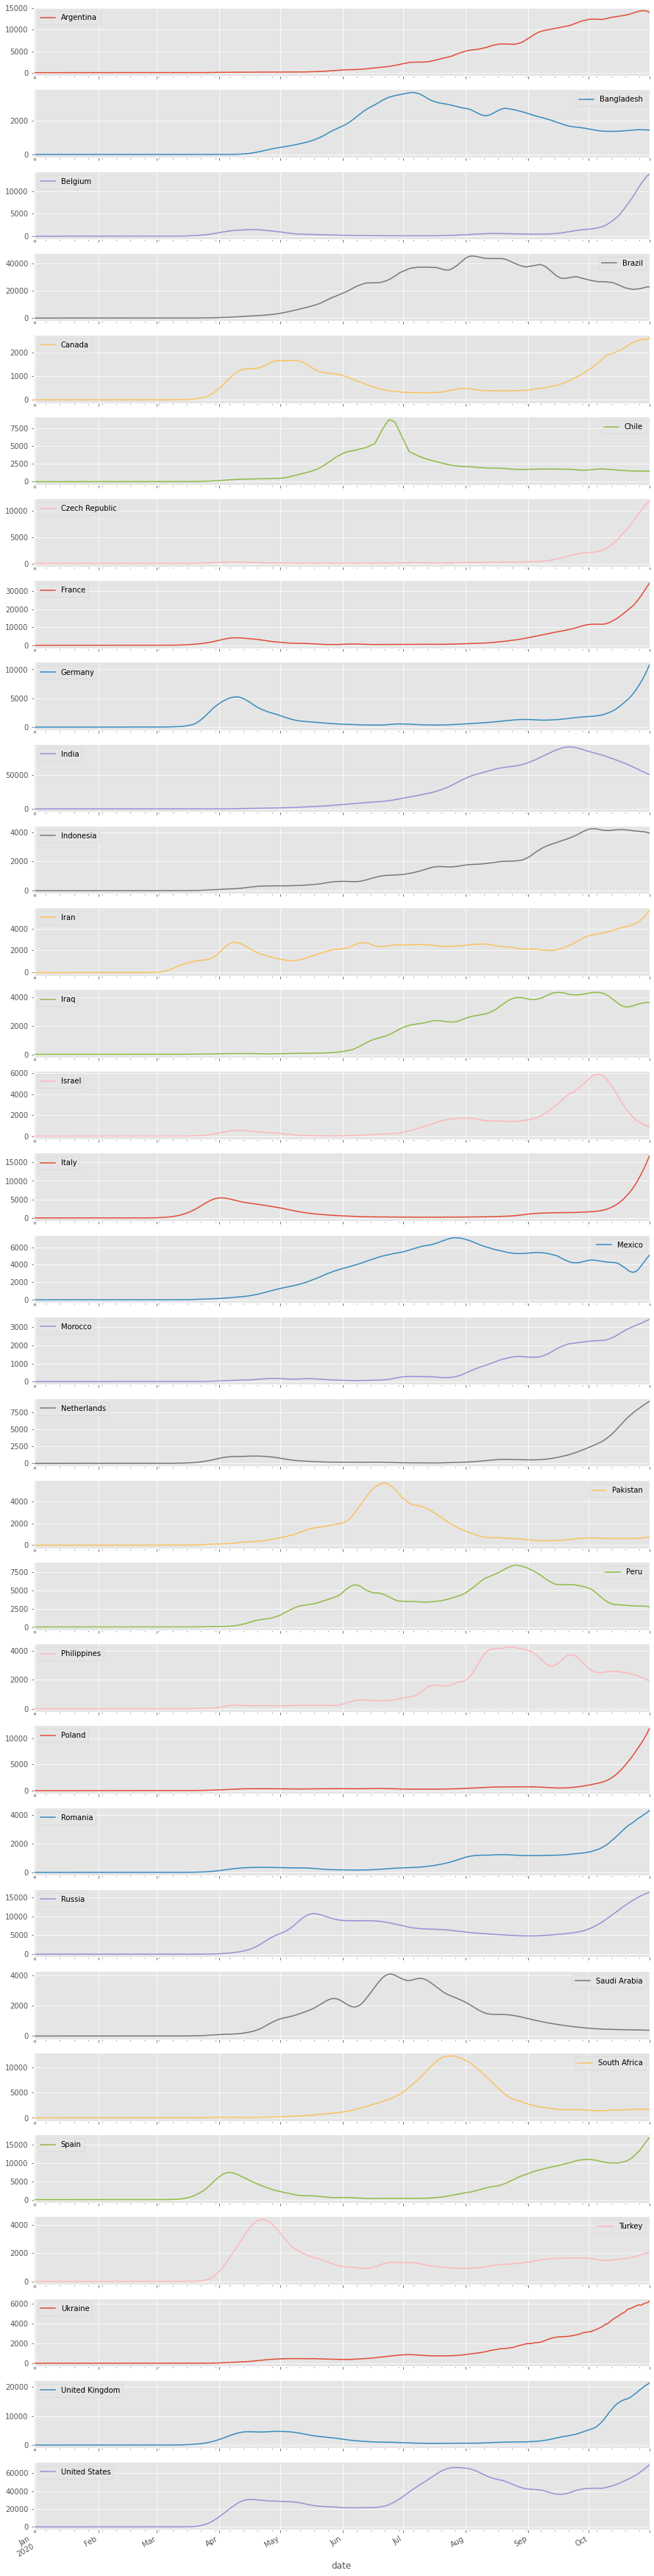

In [32]:
smooth = 10
df_join[contries_top].iloc[:,:].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(subplots=True, figsize=(15,70));

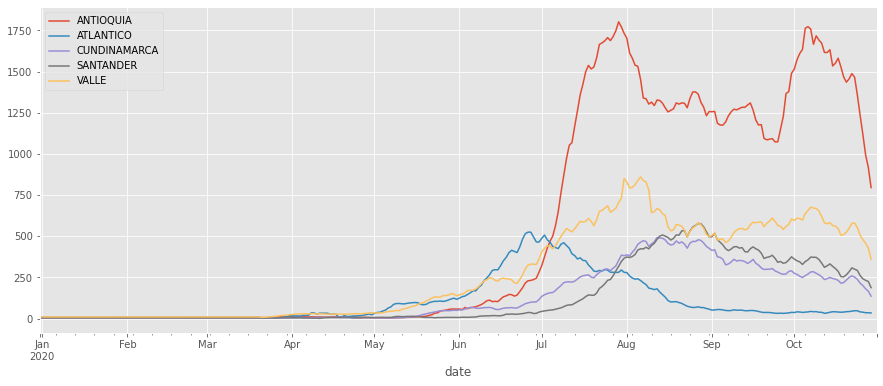

In [33]:
df_join[departamentos_iniciales].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

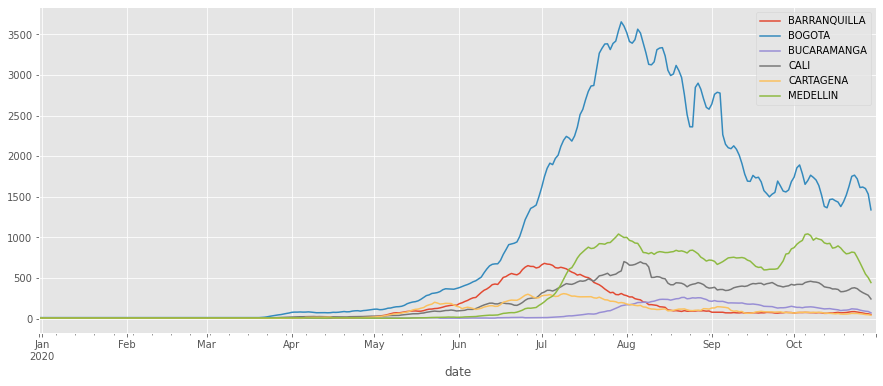

In [34]:
df_join[ciudades_iniciales].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

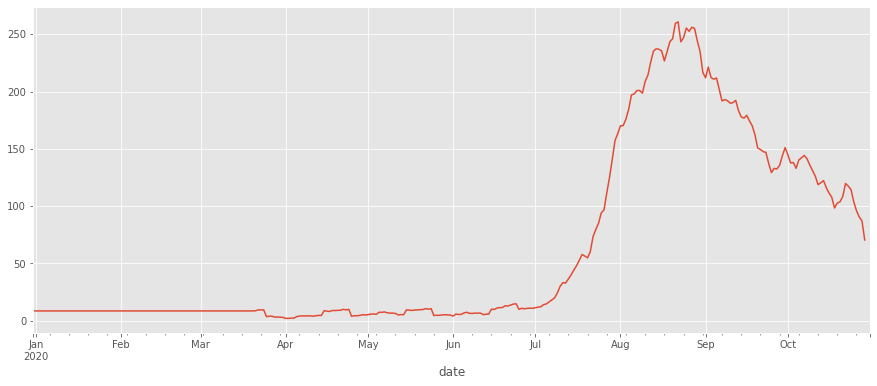

In [35]:
df_join['BUCARAMANGA'].rolling(smooth).mean().fillna(axis=0, method='backfill', inplace=False).plot(figsize=(15,6));

## Análitica inicial 

In [36]:
# parametros compartidos
# tamaño de la ventana
window_size = 21
# número de batches
batch_size = 1
# número de días a predecir
future_steps = 14
# usar stateful en los modelos
stateful = False
# estandrizar las series temporales
standarization = False
# diferenciar las series con un determinado lag
differentiation, lag = False, 1
# suavizar las series temporales 
smoothing, smooth = False, 7
# rango de fechas para seleccionar las series
initial_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d') 
final_date = datetime.datetime.strptime('2020-10-29', '%Y-%m-%d')
# rango de fechas para entrenar y testear (última ventana futura más 7 días)
train_final_date = datetime.datetime.strptime('2020-09-18', '%Y-%m-%d')

In [37]:
#@title Funciones para analizar las series | Créditos:github.com/madagra/
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res
    
    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

def ts_analysis_plots(data, n_lags=100):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelacción
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")    

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)
            
    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat
    
    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Fecha", ylabel="Vslores", 
               title=f"Casos COVID-19 en Bucaramanga (ADF p-value: {round(adf[1], 6)})")
        
    # histogram of value distribution
    axs[1].hist(data, bins=20, width = 3, color='#0504aa',alpha=0.7)
    axs[1].set(xlabel="Casos", ylabel="Frecuencia", title="Distribución de casos COVID-19")
    
    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="Valor ACF")
    
    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="Valor PACF")
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


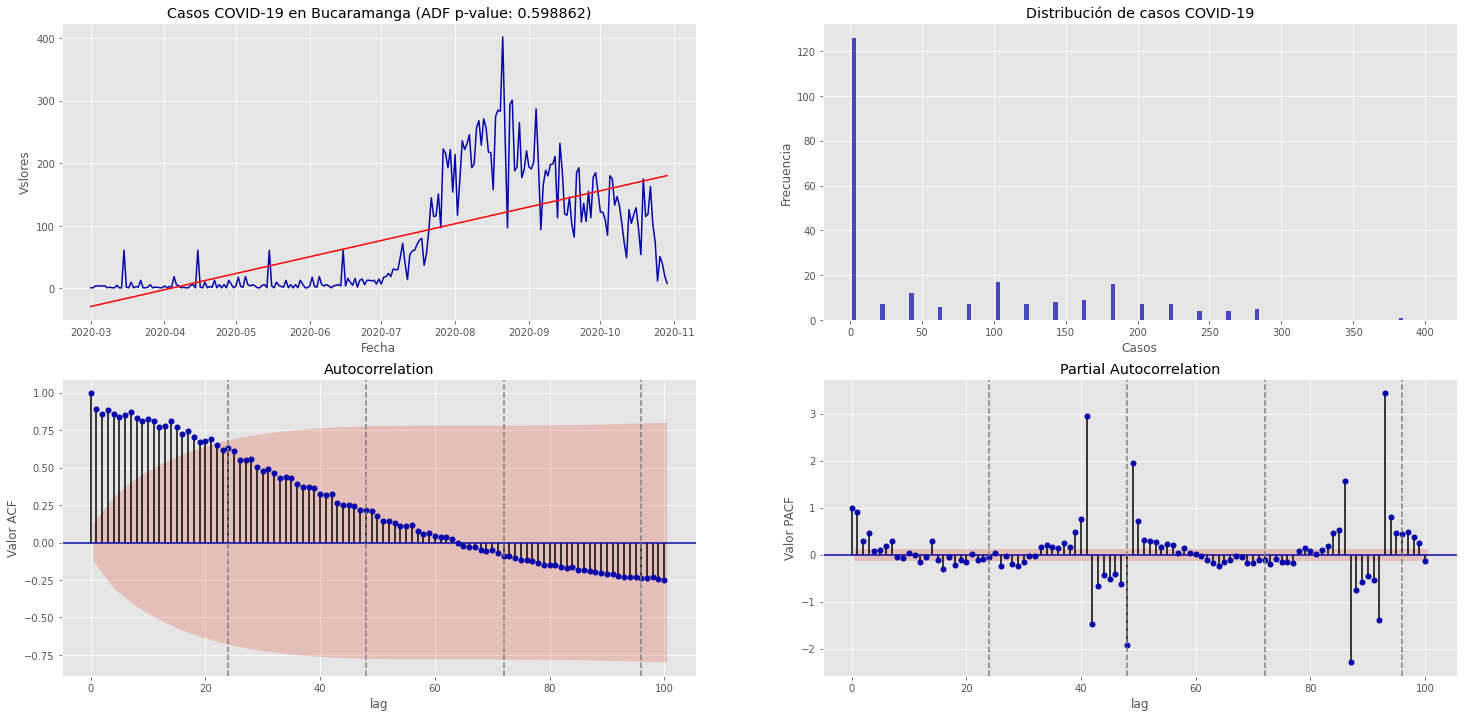

In [38]:
serie_bucaramanga = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date), 'BUCARAMANGA'].fillna(axis=0, method='backfill', inplace=False)
ts_analysis_plots(serie_bucaramanga)

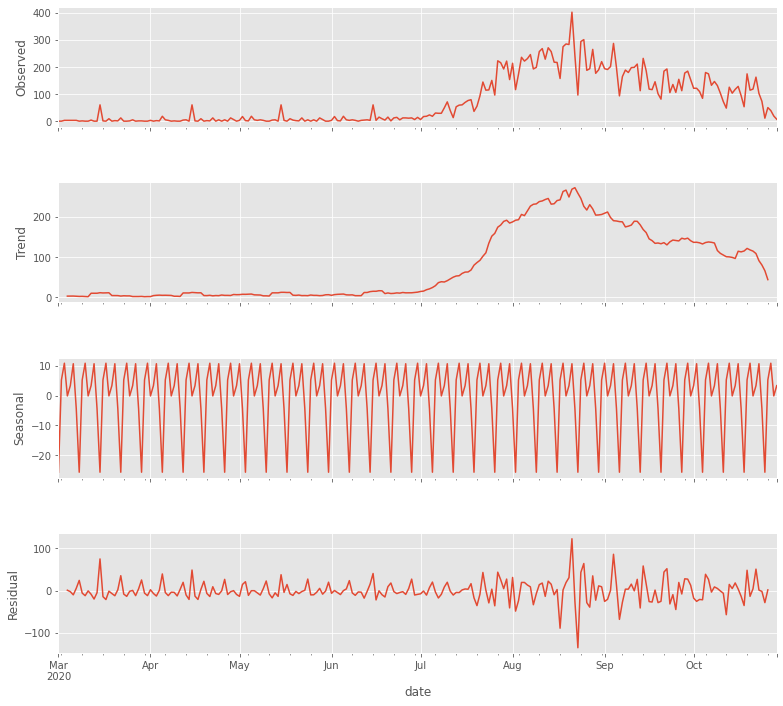

In [39]:
res = seasonal_decompose(serie_bucaramanga, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))

### Método de ensamblado (ML y DL) para la predicción de COVID-19 en Bucaramanga

In [ ]:
# Modelos
# ML
1. SVR -- DIRECTO
2. SVR -- RECURSIVO
3. XGBOOST -- DIRECTO
4. XGBOOST -- RECURSIVO
# DL
5. RNN -- DIRECTO 2 - BUCARAMANGA
6. RNN -- DIRECTO 2 - DEMAS SERIES
7. RNN -- AUTOREGRESIVO - BUCARAMANGA
8. RNN -- AUTOREGRESIVO - DEMÁS SERIES

# Modelos basados en DL

In [40]:
# Dataset con ventaneo
def windowed_dataset(series, 
                    past_window = 20, 
                    batch_size = 32, 
                    shuffle_buffer = 1000, 
                    future_window = 12,
                    col_test_series = 41):
    """
    Crea el dataset con ventaneo para realizar las predicciones de covid
    Parametros de entrada: past_window, batch_size, future_window, col_test_series 
    Retorna un dataset tf.data.dataset con la estructura definida
    """
    # Convertir la serie a tensor
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # La ventana será igual al numero de pasos del historico + los del futuro
    # Crea la ventana con una translación == shift=1. 
    # drop_remainder mantiene el numero de elementos en la ventana de las mismas dimensiones.
    # [[0, 1, 2, 3],
    #  [0, 1, 2, 3]]
    # [[1, 2, 3, 4],
    #  [1, 2, 3, 4]]
    # [[2, 3, 4, 5],
    #  [2, 3, 4, 5]]
    dataset = dataset.window(past_window+future_window, shift=1, drop_remainder=True)
    # Convertir a formato array
    dataset = dataset.flat_map(lambda window: window.batch(past_window+future_window))
    # Divide la ventana en pasado y futuro --> Es decir separa la ventana en features y target
    # Es posible predecir una o mas series para lo que se debe especificar que columna se desea predecir
    # [[0, 1, 2, 3],
    #  [0, 1, 2, 3]][4,5,6]
    # [[1, 2, 3, 4],
    #  [1, 2, 3, 4]][5,6,7]
    # [[2, 3, 4, 5],
    #  [2, 3, 4, 5]][6,7,8]
    dataset = dataset.map(lambda window: (window[:-future_window,:], window[-future_window:,col_test_series]))
    # Aplica cache y shuffle para hacer muestras independientes y evitar sesgos en las secuencia
    dataset = dataset.cache().shuffle(shuffle_buffer, reshuffle_each_iteration=True)
    # Genera los batch de datos y define el prefetch
    # x = [[[0, 1, 2, 3],
    #      [0, 1, 2, 3]], 
    #      [[4, 5, 6, 7],
    #       [4, 5, 6, 7]]
    # y = [[4,6,7], [8,9,10]]
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [41]:
def series_transformer(series_df, standarization, scaler=None):
    # inputar valores faltantes sobre la(s) serie(s)
    series_transformed = series_df.fillna(axis=0, method='backfill', inplace=False)
    # estandarizar la(s) serie(s) de tiempo
    if standarization and scaler==None: # no hay entonces ajuste uno
        scaler = StandardScaler()
        scaler = scaler.fit(series_transformed.values)
        values = scaler.transform(series_transformed.values)
        series_transformed = pd.DataFrame(data=values, 
                                          columns=series_transformed.keys(), 
                                          index = series_transformed.index )
    elif standarization and scaler!=None: # estandarizar con uno existente (test)
        values = scaler.transform(series_transformed.values)
        series_transformed = pd.DataFrame(data=values, 
                                          columns=series_transformed.keys(), 
                                          index = series_transformed.index )    
    
    return series_transformed, scaler 

### Modelo 5 - RNN Directo sobre Bucaramanga

In [45]:
# número de series a usar
feature_dim = 1
# indice de la columna a predecir
col_to_predict = 0 # Columna casos nuevos

In [46]:
def build_standard_model(hp):
    """
    Crea y optimiza el modelo para la predicción directa de casos covid 
    Parametros de entrada: hp (objeto optimizador)
    Parametros globales: window_size, feature_dim, batch_size, stateful 
    Salida: Mejor modelo encontrado sobre el espacio de busqueda definido
    """
    # limpuar la gráfica y la sección
    tf.keras.backend.clear_session()
    gc.collect()
    # construir el modelo
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [47]:
# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    project_name='model_5'
)

In [48]:
# crear los datasets para entrenamiento y test según las fechas
final_data = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date)]
final_data_train = final_data.loc[final_data.index<=train_final_date]
final_data_test =  final_data.loc[final_data.index>train_final_date]

In [49]:
# Crear el dataset de entrenamiento
final_data_train, scaler  = series_transformer(final_data_train['BUCARAMANGA'].to_frame(), standarization=True, scaler=None)
dataset_train = windowed_dataset(final_data_train['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=0)

In [50]:
# crear el dataset de test
# transformar la de test 
final_data_test, scaler = series_transformer(final_data_test['BUCARAMANGA'].to_frame(), standarization=True, scaler=scaler)
dataset_test = windowed_dataset(final_data_test['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=0)

In [51]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dataset_train,
             validation_data=dataset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0937 - mean_absolute_error: 0.8730 - val_loss: 0.3319 - val_mean_absolute_error: 0.4898
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0918 - mean_absolute_error: 0.8720 - val_loss: 0.3317 - val_mean_absolute_error: 0.4897


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 0.5012 - mean_absolute_error: 0.5246 - val_loss: 0.4666 - val_mean_absolute_error: 0.5664
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.1957 - mean_absolute_error: 0.2941 - val_loss: 0.7042 - val_mean_absolute_error: 0.7158


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 1.0808 - mean_absolute_error: 0.8677 - val_loss: 0.3255 - val_mean_absolute_error: 0.4870
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0809 - mean_absolute_error: 0.8674 - val_loss: 0.3253 - val_mean_absolute_error: 0.4868


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0977 - mean_absolute_error: 0.8754 - val_loss: 0.3306 - val_mean_absolute_error: 0.4902
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.1026 - mean_absolute_error: 0.8761 - val_loss: 0.3306 - val_mean_absolute_error: 0.4902


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0637 - mean_absolute_error: 0.8583 - val_loss: 0.3208 - val_mean_absolute_error: 0.4820
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.0627 - mean_absolute_error: 0.8579 - val_loss: 0.3206 - val_mean_absolute_error: 0.4818


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0835 - mean_absolute_error: 0.8646 - val_loss: 0.3234 - val_mean_absolute_error: 0.4824
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0799 - mean_absolute_error: 0.8638 - val_loss: 0.3234 - val_mean_absolute_error: 0.4824


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0632 - mean_absolute_error: 0.8557 - val_loss: 0.3266 - val_mean_absolute_error: 0.4860
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.0638 - mean_absolute_error: 0.8555 - val_loss: 0.3265 - val_mean_absolute_error: 0.4859


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0882 - mean_absolute_error: 0.8694 - val_loss: 0.3309 - val_mean_absolute_error: 0.4906
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.0861 - mean_absolute_error: 0.8689 - val_loss: 0.3285 - val_mean_absolute_error: 0.4889


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.0386 - mean_absolute_error: 0.8453 - val_loss: 0.3298 - val_mean_absolute_error: 0.4887
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0296 - mean_absolute_error: 0.8407 - val_loss: 0.3281 - val_mean_absolute_error: 0.4875


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.9906 - mean_absolute_error: 0.8224 - val_loss: 0.2567 - val_mean_absolute_error: 0.4199
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.4912 - mean_absolute_error: 0.5211 - val_loss: 0.9167 - val_mean_absolute_error: 0.8312


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 1.0374 - mean_absolute_error: 0.8466 - val_loss: 0.3120 - val_mean_absolute_error: 0.4764
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0333 - mean_absolute_error: 0.8452 - val_loss: 0.3099 - val_mean_absolute_error: 0.4746


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0481 - mean_absolute_error: 0.8506 - val_loss: 0.3223 - val_mean_absolute_error: 0.4826
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0121 - mean_absolute_error: 0.8348 - val_loss: 0.3140 - val_mean_absolute_error: 0.4770


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.0841 - mean_absolute_error: 0.8676 - val_loss: 0.3256 - val_mean_absolute_error: 0.4861
Epoch 2/2
168/168 [==============================] - 2s 9ms/step - loss: 1.0827 - mean_absolute_error: 0.8678 - val_loss: 0.3256 - val_mean_absolute_error: 0.4860


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0778 - mean_absolute_error: 0.8640 - val_loss: 0.3149 - val_mean_absolute_error: 0.4784
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0347 - mean_absolute_error: 0.8485 - val_loss: 0.3020 - val_mean_absolute_error: 0.4686


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0590 - mean_absolute_error: 0.8580 - val_loss: 0.3264 - val_mean_absolute_error: 0.4874
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0589 - mean_absolute_error: 0.8574 - val_loss: 0.3262 - val_mean_absolute_error: 0.4872


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0588 - mean_absolute_error: 0.8515 - val_loss: 0.3138 - val_mean_absolute_error: 0.4779
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0131 - mean_absolute_error: 0.8326 - val_loss: 0.3044 - val_mean_absolute_error: 0.4711


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0992 - mean_absolute_error: 0.8755 - val_loss: 0.3304 - val_mean_absolute_error: 0.4926
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.1016 - mean_absolute_error: 0.8763 - val_loss: 0.3303 - val_mean_absolute_error: 0.4925


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.0566 - mean_absolute_error: 0.8562 - val_loss: 0.3227 - val_mean_absolute_error: 0.4857
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0569 - mean_absolute_error: 0.8562 - val_loss: 0.3226 - val_mean_absolute_error: 0.4856


Epoch 1/2
168/168 [==============================] - 1s 9ms/step - loss: 1.1306 - mean_absolute_error: 0.8781 - val_loss: 0.3533 - val_mean_absolute_error: 0.5020
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.1072 - mean_absolute_error: 0.8690 - val_loss: 0.3508 - val_mean_absolute_error: 0.5007


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.0650 - mean_absolute_error: 0.8602 - val_loss: 0.3155 - val_mean_absolute_error: 0.4791
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0436 - mean_absolute_error: 0.8539 - val_loss: 0.3052 - val_mean_absolute_error: 0.4708


Epoch 1/2
168/168 [==============================] - 1s 9ms/step - loss: 1.0887 - mean_absolute_error: 0.8703 - val_loss: 0.3262 - val_mean_absolute_error: 0.4867
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0403 - mean_absolute_error: 0.8505 - val_loss: 0.3157 - val_mean_absolute_error: 0.4787


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.0856 - mean_absolute_error: 0.8699 - val_loss: 0.3256 - val_mean_absolute_error: 0.4869
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0852 - mean_absolute_error: 0.8697 - val_loss: 0.3256 - val_mean_absolute_error: 0.4869


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 0.6411 - mean_absolute_error: 0.6148 - val_loss: 0.4453 - val_mean_absolute_error: 0.5467
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.2051 - mean_absolute_error: 0.3058 - val_loss: 0.6022 - val_mean_absolute_error: 0.6511


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.5872 - mean_absolute_error: 0.5817 - val_loss: 0.7343 - val_mean_absolute_error: 0.7395
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.2642 - mean_absolute_error: 0.3476 - val_loss: 0.8431 - val_mean_absolute_error: 0.7975


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.7755 - mean_absolute_error: 0.7051 - val_loss: 0.3474 - val_mean_absolute_error: 0.4806
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.2146 - mean_absolute_error: 0.3112 - val_loss: 1.2099 - val_mean_absolute_error: 0.9975


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.0809 - mean_absolute_error: 0.8676 - val_loss: 0.3104 - val_mean_absolute_error: 0.4742
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0340 - mean_absolute_error: 0.8479 - val_loss: 0.2945 - val_mean_absolute_error: 0.4619


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.0695 - mean_absolute_error: 0.8627 - val_loss: 0.3271 - val_mean_absolute_error: 0.4885
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0673 - mean_absolute_error: 0.8621 - val_loss: 0.3259 - val_mean_absolute_error: 0.4876


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.0604 - mean_absolute_error: 0.8573 - val_loss: 0.3269 - val_mean_absolute_error: 0.4878
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0588 - mean_absolute_error: 0.8565 - val_loss: 0.3266 - val_mean_absolute_error: 0.4876


Epoch 1/2
168/168 [==============================] - 1s 9ms/step - loss: 1.0853 - mean_absolute_error: 0.8680 - val_loss: 0.3194 - val_mean_absolute_error: 0.4824
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.0354 - mean_absolute_error: 0.8463 - val_loss: 0.3115 - val_mean_absolute_error: 0.4760


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 0.7561 - mean_absolute_error: 0.6882 - val_loss: 0.3682 - val_mean_absolute_error: 0.4890
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.2429 - mean_absolute_error: 0.3412 - val_loss: 1.1431 - val_mean_absolute_error: 0.9535


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1605 - mean_absolute_error: 0.8979 - val_loss: 0.3389 - val_mean_absolute_error: 0.4934
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.1578 - mean_absolute_error: 0.8973 - val_loss: 0.3379 - val_mean_absolute_error: 0.4927


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 1.0785 - mean_absolute_error: 0.8641 - val_loss: 0.3306 - val_mean_absolute_error: 0.4905
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0815 - mean_absolute_error: 0.8646 - val_loss: 0.3306 - val_mean_absolute_error: 0.4905


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 0.6896 - mean_absolute_error: 0.6505 - val_loss: 0.4137 - val_mean_absolute_error: 0.5082
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.3522 - mean_absolute_error: 0.4268 - val_loss: 0.4881 - val_mean_absolute_error: 0.5802


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0835 - mean_absolute_error: 0.8691 - val_loss: 0.3226 - val_mean_absolute_error: 0.4841
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.9962 - mean_absolute_error: 0.8299 - val_loss: 0.3005 - val_mean_absolute_error: 0.4668


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 0.7193 - mean_absolute_error: 0.6635 - val_loss: 0.4709 - val_mean_absolute_error: 0.5684
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3225 - mean_absolute_error: 0.3956 - val_loss: 0.8119 - val_mean_absolute_error: 0.7942


Epoch 3/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0411 - mean_absolute_error: 0.8482 - val_loss: 0.3191 - val_mean_absolute_error: 0.4795
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9946 - mean_absolute_error: 0.8272 - val_loss: 0.3057 - val_mean_absolute_error: 0.4701


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0253 - mean_absolute_error: 0.8434 - val_loss: 0.3104 - val_mean_absolute_error: 0.4750
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.9565 - mean_absolute_error: 0.8108 - val_loss: 0.2939 - val_mean_absolute_error: 0.4614


Epoch 3/4
168/168 [==============================] - 2s 10ms/step - loss: 1.0292 - mean_absolute_error: 0.8416 - val_loss: 0.2975 - val_mean_absolute_error: 0.4647
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.9709 - mean_absolute_error: 0.8145 - val_loss: 0.2737 - val_mean_absolute_error: 0.4446


Epoch 3/4
168/168 [==============================] - 2s 15ms/step - loss: 1.0623 - mean_absolute_error: 0.8585 - val_loss: 0.3184 - val_mean_absolute_error: 0.4818
Epoch 4/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0487 - mean_absolute_error: 0.8554 - val_loss: 0.3118 - val_mean_absolute_error: 0.4762


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0371 - mean_absolute_error: 0.8384 - val_loss: 0.3164 - val_mean_absolute_error: 0.4791
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9900 - mean_absolute_error: 0.8140 - val_loss: 0.3022 - val_mean_absolute_error: 0.4683


Epoch 3/4
168/168 [==============================] - 2s 14ms/step - loss: 1.1021 - mean_absolute_error: 0.8757 - val_loss: 0.3286 - val_mean_absolute_error: 0.4892
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1029 - mean_absolute_error: 0.8760 - val_loss: 0.3274 - val_mean_absolute_error: 0.4884


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9710 - mean_absolute_error: 0.8160 - val_loss: 0.2869 - val_mean_absolute_error: 0.4554
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.8239 - mean_absolute_error: 0.7445 - val_loss: 0.2552 - val_mean_absolute_error: 0.4253


Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 0.9856 - mean_absolute_error: 0.8175 - val_loss: 0.2901 - val_mean_absolute_error: 0.4541
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.8967 - mean_absolute_error: 0.7730 - val_loss: 0.2698 - val_mean_absolute_error: 0.4361


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9709 - mean_absolute_error: 0.8156 - val_loss: 0.2988 - val_mean_absolute_error: 0.4653
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.8806 - mean_absolute_error: 0.7723 - val_loss: 0.2805 - val_mean_absolute_error: 0.4495


Epoch 3/4
168/168 [==============================] - 2s 10ms/step - loss: 0.7146 - mean_absolute_error: 0.6486 - val_loss: 0.4131 - val_mean_absolute_error: 0.5281
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2102 - mean_absolute_error: 0.3078 - val_loss: 1.1731 - val_mean_absolute_error: 0.9723


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0797 - mean_absolute_error: 0.8651 - val_loss: 0.3303 - val_mean_absolute_error: 0.4914
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0788 - mean_absolute_error: 0.8647 - val_loss: 0.3301 - val_mean_absolute_error: 0.4912


Epoch 5/10
168/168 [==============================] - 1s 9ms/step - loss: 1.1023 - mean_absolute_error: 0.8781 - val_loss: 0.3264 - val_mean_absolute_error: 0.4886
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.9998 - mean_absolute_error: 0.8324 - val_loss: 0.3146 - val_mean_absolute_error: 0.4795
Epoch 7/10
168/168 [==============================] - 1s 5ms/step - loss: 0.9131 - mean_absolute_error: 0.7907 - val_loss: 0.3058 - val_mean_absolute_error: 0.4702
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8276 - mean_absolute_error: 0.7451 - val_loss: 0.2990 - val_mean_absolute_error: 0.4589
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.7379 - mean_absolute_error: 0.6926 - val_loss: 0.2947 - val_mean_absolute_error: 0.4546
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.6446 - mean_absolute_error: 0.6346 - val_loss: 0.2932 - val_mean_absolute_error: 0.4527


Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0224 - mean_absolute_error: 0.8363 - val_loss: 0.3089 - val_mean_absolute_error: 0.4745
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.9532 - mean_absolute_error: 0.8050 - val_loss: 0.2916 - val_mean_absolute_error: 0.4622
Epoch 7/10
168/168 [==============================] - 1s 5ms/step - loss: 0.8688 - mean_absolute_error: 0.7644 - val_loss: 0.2715 - val_mean_absolute_error: 0.4454
Epoch 8/10
168/168 [==============================] - 1s 5ms/step - loss: 0.7743 - mean_absolute_error: 0.7135 - val_loss: 0.2504 - val_mean_absolute_error: 0.4245
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.6691 - mean_absolute_error: 0.6505 - val_loss: 0.2350 - val_mean_absolute_error: 0.4058
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.5470 - mean_absolute_error: 0.5724 - val_loss: 0.2320 - val_mean_absolute_error: 0.3958


Epoch 5/10
168/168 [==============================] - 2s 10ms/step - loss: 1.0759 - mean_absolute_error: 0.8598 - val_loss: 0.3216 - val_mean_absolute_error: 0.4840
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9909 - mean_absolute_error: 0.8234 - val_loss: 0.3113 - val_mean_absolute_error: 0.4740
Epoch 7/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9433 - mean_absolute_error: 0.7951 - val_loss: 0.3021 - val_mean_absolute_error: 0.4685
Epoch 8/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8936 - mean_absolute_error: 0.7648 - val_loss: 0.2947 - val_mean_absolute_error: 0.4628
Epoch 9/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8588 - mean_absolute_error: 0.7409 - val_loss: 0.2905 - val_mean_absolute_error: 0.4570
Epoch 10/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7997 - mean_absolute_error: 0.7092 - val_loss: 0.2933 - val_mean_absolute_error: 0.4521


Epoch 5/10
168/168 [==============================] - 1s 9ms/step - loss: 1.0948 - mean_absolute_error: 0.8684 - val_loss: 0.3104 - val_mean_absolute_error: 0.4718
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 1.0249 - mean_absolute_error: 0.8388 - val_loss: 0.2950 - val_mean_absolute_error: 0.4601
Epoch 7/10
168/168 [==============================] - 1s 5ms/step - loss: 0.9505 - mean_absolute_error: 0.8037 - val_loss: 0.2795 - val_mean_absolute_error: 0.4475
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8685 - mean_absolute_error: 0.7616 - val_loss: 0.2634 - val_mean_absolute_error: 0.4337
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.7666 - mean_absolute_error: 0.7069 - val_loss: 0.2461 - val_mean_absolute_error: 0.4178
Epoch 10/10
168/168 [==============================] - 1s 6ms/step - loss: 0.6803 - mean_absolute_error: 0.6530 - val_loss: 0.2330 - val_mean_absolute_error: 0.4032


Epoch 11/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0780 - mean_absolute_error: 0.8666 - val_loss: 0.3082 - val_mean_absolute_error: 0.4728
Epoch 12/30
168/168 [==============================] - 1s 6ms/step - loss: 0.9729 - mean_absolute_error: 0.8203 - val_loss: 0.2859 - val_mean_absolute_error: 0.4535
Epoch 13/30
168/168 [==============================] - 1s 6ms/step - loss: 0.8652 - mean_absolute_error: 0.7670 - val_loss: 0.2647 - val_mean_absolute_error: 0.4333
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7527 - mean_absolute_error: 0.7028 - val_loss: 0.2450 - val_mean_absolute_error: 0.4130
Epoch 15/30
168/168 [==============================] - 1s 5ms/step - loss: 0.6290 - mean_absolute_error: 0.6243 - val_loss: 0.2327 - val_mean_absolute_error: 0.3985
Epoch 16/30
168/168 [==============================] - 1s 5ms/step - loss: 0.5374 - mean_absolute_error: 0.5572 - val_loss: 0.2350 - val_mean_absolute_error: 0.3956
Epoch 17/3

Epoch 11/30
168/168 [==============================] - 1s 9ms/step - loss: 1.0107 - mean_absolute_error: 0.8320 - val_loss: 0.2935 - val_mean_absolute_error: 0.4596
Epoch 12/30
168/168 [==============================] - 1s 5ms/step - loss: 0.8991 - mean_absolute_error: 0.7795 - val_loss: 0.2689 - val_mean_absolute_error: 0.4369
Epoch 13/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7830 - mean_absolute_error: 0.7184 - val_loss: 0.2469 - val_mean_absolute_error: 0.4150
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.6505 - mean_absolute_error: 0.6437 - val_loss: 0.2330 - val_mean_absolute_error: 0.4012
Epoch 15/30
168/168 [==============================] - 1s 6ms/step - loss: 0.5214 - mean_absolute_error: 0.5641 - val_loss: 0.2326 - val_mean_absolute_error: 0.3952
Epoch 16/30
168/168 [==============================] - 1s 5ms/step - loss: 0.4545 - mean_absolute_error: 0.5028 - val_loss: 0.2529 - val_mean_absolute_error: 0.4100
Epoch 17/3

Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 0.9980 - mean_absolute_error: 0.8246 - val_loss: 0.2994 - val_mean_absolute_error: 0.4642
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 0.9035 - mean_absolute_error: 0.7782 - val_loss: 0.2776 - val_mean_absolute_error: 0.4447
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 0.8313 - mean_absolute_error: 0.7404 - val_loss: 0.2600 - val_mean_absolute_error: 0.4260
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.7247 - mean_absolute_error: 0.6781 - val_loss: 0.2468 - val_mean_absolute_error: 0.4083


Epoch 1/4
168/168 [==============================] - 2s 12ms/step - loss: 0.6458 - mean_absolute_error: 0.6106 - val_loss: 0.3392 - val_mean_absolute_error: 0.4681
Epoch 2/4
168/168 [==============================] - 1s 7ms/step - loss: 0.3917 - mean_absolute_error: 0.4434 - val_loss: 0.3719 - val_mean_absolute_error: 0.4951
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3238 - mean_absolute_error: 0.3980 - val_loss: 0.6289 - val_mean_absolute_error: 0.6507
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2763 - mean_absolute_error: 0.3711 - val_loss: 0.9482 - val_mean_absolute_error: 0.8512


Epoch 1/4
168/168 [==============================] - 2s 15ms/step - loss: 1.0655 - mean_absolute_error: 0.8615 - val_loss: 0.3095 - val_mean_absolute_error: 0.4741
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0349 - mean_absolute_error: 0.8482 - val_loss: 0.2981 - val_mean_absolute_error: 0.4649
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0048 - mean_absolute_error: 0.8342 - val_loss: 0.2841 - val_mean_absolute_error: 0.4529
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9631 - mean_absolute_error: 0.8148 - val_loss: 0.2672 - val_mean_absolute_error: 0.4370


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1521 - mean_absolute_error: 0.8955 - val_loss: 0.3391 - val_mean_absolute_error: 0.4948
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 1.1499 - mean_absolute_error: 0.8947 - val_loss: 0.3391 - val_mean_absolute_error: 0.4948
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 1.1472 - mean_absolute_error: 0.8932 - val_loss: 0.3391 - val_mean_absolute_error: 0.4947
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.1438 - mean_absolute_error: 0.8933 - val_loss: 0.3391 - val_mean_absolute_error: 0.4947


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0550 - mean_absolute_error: 0.8538 - val_loss: 0.3217 - val_mean_absolute_error: 0.4834
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0458 - mean_absolute_error: 0.8505 - val_loss: 0.3191 - val_mean_absolute_error: 0.4813
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0355 - mean_absolute_error: 0.8471 - val_loss: 0.3166 - val_mean_absolute_error: 0.4793
Epoch 4/4
168/168 [==============================] - 2s 9ms/step - loss: 1.0312 - mean_absolute_error: 0.8444 - val_loss: 0.3138 - val_mean_absolute_error: 0.4772


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 0.7881 - mean_absolute_error: 0.7032 - val_loss: 0.2756 - val_mean_absolute_error: 0.4135
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3522 - mean_absolute_error: 0.4236 - val_loss: 0.5764 - val_mean_absolute_error: 0.6408
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 0.2957 - mean_absolute_error: 0.3785 - val_loss: 0.5569 - val_mean_absolute_error: 0.6291
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2689 - mean_absolute_error: 0.3621 - val_loss: 0.5152 - val_mean_absolute_error: 0.5971


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0394 - mean_absolute_error: 0.8469 - val_loss: 0.3096 - val_mean_absolute_error: 0.4740
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0391 - mean_absolute_error: 0.8468 - val_loss: 0.3094 - val_mean_absolute_error: 0.4739
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0388 - mean_absolute_error: 0.8467 - val_loss: 0.3093 - val_mean_absolute_error: 0.4738
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0385 - mean_absolute_error: 0.8466 - val_loss: 0.3092 - val_mean_absolute_error: 0.4737


Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0474 - mean_absolute_error: 0.8479 - val_loss: 0.3006 - val_mean_absolute_error: 0.4637
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9155 - mean_absolute_error: 0.7878 - val_loss: 0.2678 - val_mean_absolute_error: 0.4345
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 0.7924 - mean_absolute_error: 0.7251 - val_loss: 0.2393 - val_mean_absolute_error: 0.4094
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.6932 - mean_absolute_error: 0.6672 - val_loss: 0.2180 - val_mean_absolute_error: 0.3875


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 1.1142 - mean_absolute_error: 0.8798 - val_loss: 0.3419 - val_mean_absolute_error: 0.4979
Epoch 2/4
168/168 [==============================] - 1s 7ms/step - loss: 1.1099 - mean_absolute_error: 0.8784 - val_loss: 0.3419 - val_mean_absolute_error: 0.4979
Epoch 3/4
168/168 [==============================] - 1s 7ms/step - loss: 1.1106 - mean_absolute_error: 0.8783 - val_loss: 0.3419 - val_mean_absolute_error: 0.4979
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 1.1139 - mean_absolute_error: 0.8800 - val_loss: 0.3418 - val_mean_absolute_error: 0.4978


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0443 - mean_absolute_error: 0.8474 - val_loss: 0.3146 - val_mean_absolute_error: 0.4780
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0323 - mean_absolute_error: 0.8415 - val_loss: 0.3118 - val_mean_absolute_error: 0.4757
Epoch 3/4
168/168 [==============================] - 1s 7ms/step - loss: 1.0149 - mean_absolute_error: 0.8339 - val_loss: 0.3083 - val_mean_absolute_error: 0.4727
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 1.0113 - mean_absolute_error: 0.8328 - val_loss: 0.3051 - val_mean_absolute_error: 0.4699


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 0.5665 - mean_absolute_error: 0.5666 - val_loss: 0.3720 - val_mean_absolute_error: 0.4968
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2210 - mean_absolute_error: 0.3164 - val_loss: 0.3938 - val_mean_absolute_error: 0.5103
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 0.2077 - mean_absolute_error: 0.3038 - val_loss: 0.3789 - val_mean_absolute_error: 0.4938
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2118 - mean_absolute_error: 0.3116 - val_loss: 0.4721 - val_mean_absolute_error: 0.5647


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0750 - mean_absolute_error: 0.8644 - val_loss: 0.3223 - val_mean_absolute_error: 0.4852
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0738 - mean_absolute_error: 0.8642 - val_loss: 0.3222 - val_mean_absolute_error: 0.4851
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0748 - mean_absolute_error: 0.8644 - val_loss: 0.3221 - val_mean_absolute_error: 0.4850
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0745 - mean_absolute_error: 0.8645 - val_loss: 0.3220 - val_mean_absolute_error: 0.4849


Epoch 1/4
168/168 [==============================] - 2s 15ms/step - loss: 1.0761 - mean_absolute_error: 0.8656 - val_loss: 0.3283 - val_mean_absolute_error: 0.4883
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0773 - mean_absolute_error: 0.8661 - val_loss: 0.3282 - val_mean_absolute_error: 0.4882
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0771 - mean_absolute_error: 0.8661 - val_loss: 0.3281 - val_mean_absolute_error: 0.4882
Epoch 4/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0766 - mean_absolute_error: 0.8659 - val_loss: 0.3280 - val_mean_absolute_error: 0.4881


Epoch 1/4
168/168 [==============================] - 2s 9ms/step - loss: 1.0462 - mean_absolute_error: 0.8477 - val_loss: 0.3283 - val_mean_absolute_error: 0.4891
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 1.0441 - mean_absolute_error: 0.8460 - val_loss: 0.3260 - val_mean_absolute_error: 0.4874
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0289 - mean_absolute_error: 0.8403 - val_loss: 0.3238 - val_mean_absolute_error: 0.4857
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0221 - mean_absolute_error: 0.8381 - val_loss: 0.3215 - val_mean_absolute_error: 0.4839


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 0.5961 - mean_absolute_error: 0.5818 - val_loss: 1.1916 - val_mean_absolute_error: 0.9855
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 0.2464 - mean_absolute_error: 0.3461 - val_loss: 1.4873 - val_mean_absolute_error: 1.1298
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.2288 - mean_absolute_error: 0.3169 - val_loss: 1.5718 - val_mean_absolute_error: 1.1601
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.1903 - mean_absolute_error: 0.2978 - val_loss: 1.2579 - val_mean_absolute_error: 1.0128


Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0477 - mean_absolute_error: 0.8489 - val_loss: 0.3028 - val_mean_absolute_error: 0.4700
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.9327 - mean_absolute_error: 0.7970 - val_loss: 0.2781 - val_mean_absolute_error: 0.4488
Epoch 7/10
168/168 [==============================] - 1s 5ms/step - loss: 0.8287 - mean_absolute_error: 0.7413 - val_loss: 0.2575 - val_mean_absolute_error: 0.4311
Epoch 8/10
168/168 [==============================] - 1s 5ms/step - loss: 0.7120 - mean_absolute_error: 0.6778 - val_loss: 0.2424 - val_mean_absolute_error: 0.4139
Epoch 9/10
168/168 [==============================] - 1s 6ms/step - loss: 0.5855 - mean_absolute_error: 0.5971 - val_loss: 0.2374 - val_mean_absolute_error: 0.4032
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.4606 - mean_absolute_error: 0.5174 - val_loss: 0.2506 - val_mean_absolute_error: 0.4068


Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9565 - mean_absolute_error: 0.8007 - val_loss: 0.2897 - val_mean_absolute_error: 0.4534
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8746 - mean_absolute_error: 0.7562 - val_loss: 0.2737 - val_mean_absolute_error: 0.4358
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7927 - mean_absolute_error: 0.7112 - val_loss: 0.2612 - val_mean_absolute_error: 0.4242
Epoch 8/10
168/168 [==============================] - 1s 5ms/step - loss: 0.7097 - mean_absolute_error: 0.6613 - val_loss: 0.2554 - val_mean_absolute_error: 0.4178
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.6395 - mean_absolute_error: 0.6165 - val_loss: 0.2557 - val_mean_absolute_error: 0.4150
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.5637 - mean_absolute_error: 0.5682 - val_loss: 0.2670 - val_mean_absolute_error: 0.4207


Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 0.6825 - mean_absolute_error: 0.6421 - val_loss: 0.2927 - val_mean_absolute_error: 0.4303
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.3341 - mean_absolute_error: 0.4112 - val_loss: 0.6583 - val_mean_absolute_error: 0.6903
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2958 - mean_absolute_error: 0.3816 - val_loss: 0.6356 - val_mean_absolute_error: 0.6804
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2890 - mean_absolute_error: 0.3739 - val_loss: 0.7068 - val_mean_absolute_error: 0.7273


Epoch 5/10
168/168 [==============================] - 2s 14ms/step - loss: 1.0781 - mean_absolute_error: 0.8682 - val_loss: 0.3259 - val_mean_absolute_error: 0.4855
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0510 - mean_absolute_error: 0.8569 - val_loss: 0.3181 - val_mean_absolute_error: 0.4791
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0214 - mean_absolute_error: 0.8456 - val_loss: 0.3072 - val_mean_absolute_error: 0.4710
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9888 - mean_absolute_error: 0.8294 - val_loss: 0.2963 - val_mean_absolute_error: 0.4627
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9307 - mean_absolute_error: 0.7999 - val_loss: 0.2856 - val_mean_absolute_error: 0.4521
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.8614 - mean_absolute_error: 0.7626 - val_loss: 0.2770 - val_mean_absolute_error: 0.4356


Epoch 5/10
168/168 [==============================] - 2s 10ms/step - loss: 0.7481 - mean_absolute_error: 0.6835 - val_loss: 0.3887 - val_mean_absolute_error: 0.5086
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3773 - mean_absolute_error: 0.4375 - val_loss: 0.7882 - val_mean_absolute_error: 0.7696
Epoch 7/10
168/168 [==============================] - 1s 7ms/step - loss: 0.3445 - mean_absolute_error: 0.4174 - val_loss: 0.5551 - val_mean_absolute_error: 0.6326
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3091 - mean_absolute_error: 0.3813 - val_loss: 0.6786 - val_mean_absolute_error: 0.6990


Epoch 11/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0419 - mean_absolute_error: 0.8447 - val_loss: 0.3032 - val_mean_absolute_error: 0.4675
Epoch 12/30
168/168 [==============================] - 1s 5ms/step - loss: 0.9347 - mean_absolute_error: 0.7946 - val_loss: 0.2782 - val_mean_absolute_error: 0.4484
Epoch 13/30
168/168 [==============================] - 1s 5ms/step - loss: 0.8457 - mean_absolute_error: 0.7449 - val_loss: 0.2573 - val_mean_absolute_error: 0.4307
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7421 - mean_absolute_error: 0.6872 - val_loss: 0.2368 - val_mean_absolute_error: 0.4086
Epoch 15/30
168/168 [==============================] - 1s 6ms/step - loss: 0.6252 - mean_absolute_error: 0.6207 - val_loss: 0.2240 - val_mean_absolute_error: 0.3910
Epoch 16/30
168/168 [==============================] - 1s 6ms/step - loss: 0.5358 - mean_absolute_error: 0.5563 - val_loss: 0.2240 - val_mean_absolute_error: 0.3825
Epoch 17/3

Epoch 11/30
168/168 [==============================] - 1s 8ms/step - loss: 0.9526 - mean_absolute_error: 0.8020 - val_loss: 0.2839 - val_mean_absolute_error: 0.4517
Epoch 12/30
168/168 [==============================] - 1s 5ms/step - loss: 0.8457 - mean_absolute_error: 0.7485 - val_loss: 0.2611 - val_mean_absolute_error: 0.4331
Epoch 13/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7635 - mean_absolute_error: 0.6993 - val_loss: 0.2440 - val_mean_absolute_error: 0.4153
Epoch 14/30
168/168 [==============================] - 1s 6ms/step - loss: 0.6245 - mean_absolute_error: 0.6196 - val_loss: 0.2335 - val_mean_absolute_error: 0.4001
Epoch 15/30
168/168 [==============================] - 1s 5ms/step - loss: 0.5311 - mean_absolute_error: 0.5560 - val_loss: 0.2367 - val_mean_absolute_error: 0.3978
Epoch 16/30
168/168 [==============================] - 1s 5ms/step - loss: 0.4577 - mean_absolute_error: 0.4987 - val_loss: 0.2558 - val_mean_absolute_error: 0.4053
Epoch 17/3

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.0591 - mean_absolute_error: 0.8578 - val_loss: 0.3205 - val_mean_absolute_error: 0.4827
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9962 - mean_absolute_error: 0.8305 - val_loss: 0.3126 - val_mean_absolute_error: 0.4781
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9299 - mean_absolute_error: 0.7994 - val_loss: 0.3073 - val_mean_absolute_error: 0.4726
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8556 - mean_absolute_error: 0.7605 - val_loss: 0.3044 - val_mean_absolute_error: 0.4698
Epoch 5/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7647 - mean_absolute_error: 0.7074 - val_loss: 0.3091 - val_mean_absolute_error: 0.4703
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.6694 - mean_absolute_error: 0.6471 - val_loss: 0.3270 - val_mean_absolute_error: 0.4719
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 1s 8ms/step - loss: 0.7766 - mean_absolute_error: 0.6990 - val_loss: 0.2447 - val_mean_absolute_error: 0.3959
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2558 - mean_absolute_error: 0.3497 - val_loss: 0.5952 - val_mean_absolute_error: 0.6556
Epoch 3/10
168/168 [==============================] - 1s 5ms/step - loss: 0.2210 - mean_absolute_error: 0.3212 - val_loss: 0.7037 - val_mean_absolute_error: 0.7185
Epoch 4/10
168/168 [==============================] - 1s 5ms/step - loss: 0.2092 - mean_absolute_error: 0.3096 - val_loss: 0.6389 - val_mean_absolute_error: 0.6737


Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.0767 - mean_absolute_error: 0.8628 - val_loss: 0.3197 - val_mean_absolute_error: 0.4825
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0668 - mean_absolute_error: 0.8603 - val_loss: 0.3176 - val_mean_absolute_error: 0.4809
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 1.0545 - mean_absolute_error: 0.8557 - val_loss: 0.3156 - val_mean_absolute_error: 0.4794
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 1.0535 - mean_absolute_error: 0.8547 - val_loss: 0.3137 - val_mean_absolute_error: 0.4780
Epoch 5/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0497 - mean_absolute_error: 0.8524 - val_loss: 0.3117 - val_mean_absolute_error: 0.4764
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0432 - mean_absolute_error: 0.8494 - val_loss: 0.3099 - val_mean_absolute_error: 0.4750
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 14ms/step - loss: 1.0688 - mean_absolute_error: 0.8618 - val_loss: 0.3249 - val_mean_absolute_error: 0.4865
Epoch 2/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0706 - mean_absolute_error: 0.8613 - val_loss: 0.3248 - val_mean_absolute_error: 0.4864
Epoch 3/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0657 - mean_absolute_error: 0.8616 - val_loss: 0.3247 - val_mean_absolute_error: 0.4864
Epoch 4/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0655 - mean_absolute_error: 0.8605 - val_loss: 0.3246 - val_mean_absolute_error: 0.4863
Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0671 - mean_absolute_error: 0.8608 - val_loss: 0.3246 - val_mean_absolute_error: 0.4862
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 1.0690 - mean_absolute_error: 0.8615 - val_loss: 0.3245 - val_mean_absolute_error: 0.4862
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.1078 - mean_absolute_error: 0.8785 - val_loss: 0.3257 - val_mean_absolute_error: 0.4856
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0313 - mean_absolute_error: 0.8464 - val_loss: 0.3072 - val_mean_absolute_error: 0.4726
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 0.9549 - mean_absolute_error: 0.8131 - val_loss: 0.2894 - val_mean_absolute_error: 0.4578
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8647 - mean_absolute_error: 0.7668 - val_loss: 0.2711 - val_mean_absolute_error: 0.4388
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.7701 - mean_absolute_error: 0.7109 - val_loss: 0.2536 - val_mean_absolute_error: 0.4188
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.6415 - mean_absolute_error: 0.6299 - val_loss: 0.2460 - val_mean_absolute_error: 0.3987
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 14ms/step - loss: 1.0784 - mean_absolute_error: 0.8660 - val_loss: 0.3278 - val_mean_absolute_error: 0.4886
Epoch 2/10
168/168 [==============================] - 1s 9ms/step - loss: 1.0755 - mean_absolute_error: 0.8652 - val_loss: 0.3278 - val_mean_absolute_error: 0.4886
Epoch 3/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0782 - mean_absolute_error: 0.8664 - val_loss: 0.3278 - val_mean_absolute_error: 0.4886
Epoch 4/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0756 - mean_absolute_error: 0.8653 - val_loss: 0.3278 - val_mean_absolute_error: 0.4886
Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0758 - mean_absolute_error: 0.8655 - val_loss: 0.3277 - val_mean_absolute_error: 0.4886
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0770 - mean_absolute_error: 0.8656 - val_loss: 0.3277 - val_mean_absolute_error: 0.4886
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.0607 - mean_absolute_error: 0.8587 - val_loss: 0.3099 - val_mean_absolute_error: 0.4737
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9973 - mean_absolute_error: 0.8297 - val_loss: 0.2905 - val_mean_absolute_error: 0.4584
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.9322 - mean_absolute_error: 0.8004 - val_loss: 0.2708 - val_mean_absolute_error: 0.4432
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8513 - mean_absolute_error: 0.7610 - val_loss: 0.2503 - val_mean_absolute_error: 0.4243
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.7415 - mean_absolute_error: 0.7032 - val_loss: 0.2307 - val_mean_absolute_error: 0.4025
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.6377 - mean_absolute_error: 0.6313 - val_loss: 0.2199 - val_mean_absolute_error: 0.3787
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 10ms/step - loss: 0.4847 - mean_absolute_error: 0.5080 - val_loss: 0.6274 - val_mean_absolute_error: 0.6739
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.2263 - mean_absolute_error: 0.3159 - val_loss: 0.7723 - val_mean_absolute_error: 0.7590
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2106 - mean_absolute_error: 0.3098 - val_loss: 0.7500 - val_mean_absolute_error: 0.7456
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.1993 - mean_absolute_error: 0.2960 - val_loss: 1.0483 - val_mean_absolute_error: 0.9059


Epoch 11/30
168/168 [==============================] - 2s 10ms/step - loss: 1.0512 - mean_absolute_error: 0.8521 - val_loss: 0.3090 - val_mean_absolute_error: 0.4741
Epoch 12/30
168/168 [==============================] - 1s 7ms/step - loss: 1.0059 - mean_absolute_error: 0.8325 - val_loss: 0.2940 - val_mean_absolute_error: 0.4617
Epoch 13/30
168/168 [==============================] - 1s 6ms/step - loss: 0.9490 - mean_absolute_error: 0.8059 - val_loss: 0.2792 - val_mean_absolute_error: 0.4475
Epoch 14/30
168/168 [==============================] - 1s 6ms/step - loss: 0.8864 - mean_absolute_error: 0.7743 - val_loss: 0.2641 - val_mean_absolute_error: 0.4316
Epoch 15/30
168/168 [==============================] - 1s 6ms/step - loss: 0.8075 - mean_absolute_error: 0.7300 - val_loss: 0.2481 - val_mean_absolute_error: 0.4127
Epoch 16/30
168/168 [==============================] - 1s 6ms/step - loss: 0.7237 - mean_absolute_error: 0.6761 - val_loss: 0.2367 - val_mean_absolute_error: 0.3952
Epoch 17/

Epoch 11/30
168/168 [==============================] - 1s 8ms/step - loss: 0.7611 - mean_absolute_error: 0.6886 - val_loss: 0.3165 - val_mean_absolute_error: 0.4428
Epoch 12/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2585 - mean_absolute_error: 0.3521 - val_loss: 0.5710 - val_mean_absolute_error: 0.6392
Epoch 13/30
168/168 [==============================] - 1s 6ms/step - loss: 0.2349 - mean_absolute_error: 0.3332 - val_loss: 0.6189 - val_mean_absolute_error: 0.6668
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2374 - mean_absolute_error: 0.3264 - val_loss: 0.6529 - val_mean_absolute_error: 0.6875


Epoch 11/30
168/168 [==============================] - 2s 10ms/step - loss: 0.9808 - mean_absolute_error: 0.8229 - val_loss: 0.2807 - val_mean_absolute_error: 0.4520
Epoch 12/30
168/168 [==============================] - 1s 7ms/step - loss: 0.8579 - mean_absolute_error: 0.7604 - val_loss: 0.2472 - val_mean_absolute_error: 0.4232
Epoch 13/30
168/168 [==============================] - 1s 7ms/step - loss: 0.6978 - mean_absolute_error: 0.6787 - val_loss: 0.2204 - val_mean_absolute_error: 0.3849
Epoch 14/30
168/168 [==============================] - 1s 7ms/step - loss: 0.5346 - mean_absolute_error: 0.5693 - val_loss: 0.2264 - val_mean_absolute_error: 0.3819
Epoch 15/30
168/168 [==============================] - 1s 6ms/step - loss: 0.3978 - mean_absolute_error: 0.4673 - val_loss: 0.2880 - val_mean_absolute_error: 0.4338
Epoch 16/30
168/168 [==============================] - 1s 6ms/step - loss: 0.3204 - mean_absolute_error: 0.4065 - val_loss: 0.3754 - val_mean_absolute_error: 0.5021
Epoch 17/

Epoch 1/30
168/168 [==============================] - 2s 13ms/step - loss: 0.6598 - mean_absolute_error: 0.6203 - val_loss: 0.4135 - val_mean_absolute_error: 0.5408
Epoch 2/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3850 - mean_absolute_error: 0.4500 - val_loss: 0.7591 - val_mean_absolute_error: 0.7519
Epoch 3/30
168/168 [==============================] - 1s 9ms/step - loss: 0.3730 - mean_absolute_error: 0.4291 - val_loss: 0.5910 - val_mean_absolute_error: 0.6509
Epoch 4/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3292 - mean_absolute_error: 0.3991 - val_loss: 0.7972 - val_mean_absolute_error: 0.7656


Epoch 1/30
168/168 [==============================] - 3s 15ms/step - loss: 1.0676 - mean_absolute_error: 0.8616 - val_loss: 0.3233 - val_mean_absolute_error: 0.4853
Epoch 2/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0652 - mean_absolute_error: 0.8611 - val_loss: 0.3219 - val_mean_absolute_error: 0.4843
Epoch 3/30
168/168 [==============================] - 2s 9ms/step - loss: 1.0599 - mean_absolute_error: 0.8589 - val_loss: 0.3205 - val_mean_absolute_error: 0.4832
Epoch 4/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0580 - mean_absolute_error: 0.8581 - val_loss: 0.3191 - val_mean_absolute_error: 0.4822
Epoch 5/30
168/168 [==============================] - 1s 9ms/step - loss: 1.0542 - mean_absolute_error: 0.8569 - val_loss: 0.3175 - val_mean_absolute_error: 0.4810
Epoch 6/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0502 - mean_absolute_error: 0.8555 - val_loss: 0.3162 - val_mean_absolute_error: 0.4800
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 2s 11ms/step - loss: 1.0925 - mean_absolute_error: 0.8714 - val_loss: 0.3333 - val_mean_absolute_error: 0.4922
Epoch 2/30
168/168 [==============================] - 1s 7ms/step - loss: 1.0855 - mean_absolute_error: 0.8685 - val_loss: 0.3310 - val_mean_absolute_error: 0.4906
Epoch 3/30
168/168 [==============================] - 1s 7ms/step - loss: 1.0763 - mean_absolute_error: 0.8646 - val_loss: 0.3286 - val_mean_absolute_error: 0.4890
Epoch 4/30
168/168 [==============================] - 1s 6ms/step - loss: 1.0708 - mean_absolute_error: 0.8626 - val_loss: 0.3264 - val_mean_absolute_error: 0.4874
Epoch 5/30
168/168 [==============================] - 1s 6ms/step - loss: 1.0658 - mean_absolute_error: 0.8600 - val_loss: 0.3242 - val_mean_absolute_error: 0.4858
Epoch 6/30
168/168 [==============================] - 1s 6ms/step - loss: 1.0569 - mean_absolute_error: 0.8565 - val_loss: 0.3220 - val_mean_absolute_error: 0.4842
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 2s 14ms/step - loss: 0.6288 - mean_absolute_error: 0.6204 - val_loss: 1.0614 - val_mean_absolute_error: 0.9089
Epoch 2/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1829 - mean_absolute_error: 0.2878 - val_loss: 1.2081 - val_mean_absolute_error: 0.9976
Epoch 3/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1582 - mean_absolute_error: 0.2579 - val_loss: 1.4685 - val_mean_absolute_error: 1.1193
Epoch 4/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1477 - mean_absolute_error: 0.2445 - val_loss: 1.4694 - val_mean_absolute_error: 1.1242


Epoch 1/30
168/168 [==============================] - 1s 8ms/step - loss: 0.5634 - mean_absolute_error: 0.5605 - val_loss: 0.3469 - val_mean_absolute_error: 0.4672
Epoch 2/30
168/168 [==============================] - 1s 6ms/step - loss: 0.3149 - mean_absolute_error: 0.3881 - val_loss: 0.4641 - val_mean_absolute_error: 0.5646
Epoch 3/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2740 - mean_absolute_error: 0.3604 - val_loss: 0.4564 - val_mean_absolute_error: 0.5570
Epoch 4/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2596 - mean_absolute_error: 0.3471 - val_loss: 0.4532 - val_mean_absolute_error: 0.5582


INFO:tensorflow:Oracle triggered exit


In [52]:
best_model_5 = tuner.get_best_models(1)[0]

In [53]:
best_hyperparameters_5 = tuner.get_best_hyperparameters(1)[0]

In [54]:
vars(best_hyperparameters_5)

{'_scopes': [],
 '_space': {'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0),
  'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01),
  'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1),
  'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)},
 'values': {'clipvalue': 10.0,
  'dropout': 0.30000000000000004,


In [55]:
best_model_5.evaluate(dataset_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.2199 - mean_absolute_error: 0.3787


[0.21991966664791107, 0.37867775559425354]

In [57]:
# predecir la última ventana de tiempo
last_future_values_x = final_data_test['BUCARAMANGA'].to_frame().iloc[-(window_size+future_steps):-future_steps,col_to_predict]
last_future_values_y = final_data_test['BUCARAMANGA'].to_frame().iloc[-future_steps:,col_to_predict]
last_future_values_y_preds = best_model_5.predict(np.expand_dims(last_future_values_x.values.reshape(-1,1), axis=0))

In [58]:
# invertir los valores reales
real_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)
real_y_pred_values_inverse = scaler.inverse_transform(last_future_values_y_preds.ravel())

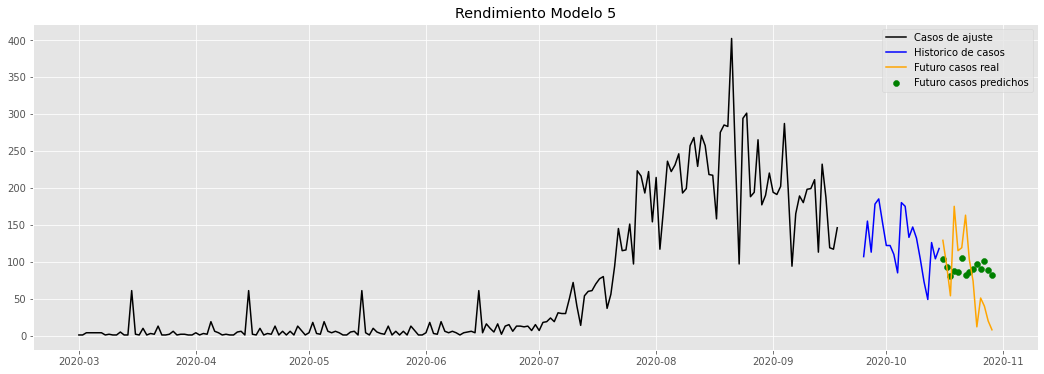

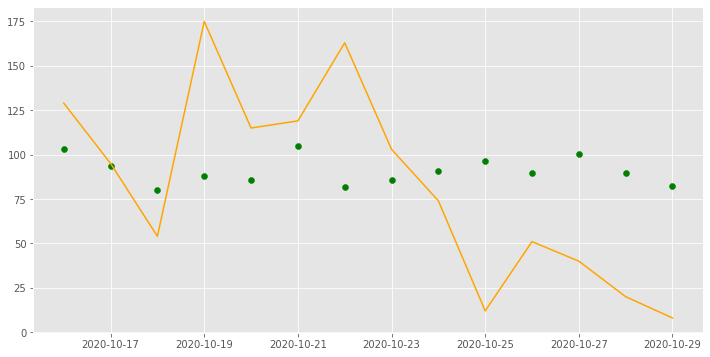

In [59]:
fig = plt.figure(figsize=(18,6))
plt.title('Rendimiento Modelo 5')
# plotear los valores de entrenamiento
plt.plot(final_data_train.index, scaler.inverse_transform(final_data_train.values.ravel()), c='black', label='Casos de ajuste');
# plotear la última ventana
plt.plot(last_future_values_x.index, scaler.inverse_transform(last_future_values_x.values), c='blue', label='Historico de casos');
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, real_y_pred_values_inverse, c='green', label='Futuro casos predichos');
plt.legend()
plt.show();
fig = plt.figure(figsize=(12,6))
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, real_y_pred_values_inverse, c='green', label='Futuro casos predichos');
plt.show();

In [56]:
predictions = best_model_5.predict(dataset_test)

In [60]:
# Guardar el mejor modelo y scaler
best_model_5.save('model_5/best_model_5.h5')
# save the scaler
pkl.dump(scaler, open('model_5/scaler_model_5.pkl', 'wb'))

In [61]:
!zip -r model_5.zip model_5/*

  adding: model_5/best_model_5.h5 (deflated 14%)
  adding: model_5/oracle.json (deflated 55%)
  adding: model_5/scaler_model_5.pkl (deflated 25%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/ (stored 0%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/checkpoints/ (stored 0%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/checkpoints/epoch_0/ (stored 0%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/checkpoints/epoch_0/checkpoint.index (deflated 53%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: model_5/trial_0100f9f0d2edccf0a3b8f0a877bd62a9/trial.json (deflated 71%)
  adding: model_5/trial_054c906abc3a9d805c52334f438da793/ (stored 0%)
  adding: model_5/trial_054c906abc3a9d805c52334f438da793/checkpoints/ (stored 0%)
  adding: model_5/trial_054c906abc3a9d805c5

### Modelo 6 RNN directo sobre todas las series

In [44]:
# crear los datasets para entrenamiento y test según las fechas
selected = contries_top + departamentos_iniciales + ciudades_iniciales 
final_data = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date), selected]
final_data_train = final_data.loc[final_data.index<=train_final_date]
final_data_test =  final_data.loc[final_data.index>train_final_date]

In [45]:
# número de series a usar
feature_dim = len(selected)
# indice de la columna a predecir
col_to_predict = final_data_train.keys().tolist().index('BUCARAMANGA') # Columna casos nuevos

In [46]:
# Crear el dataset de entrenamiento
final_data_train, scaler  = series_transformer(final_data_train, standarization=True, scaler=None)
dataset_train = windowed_dataset(final_data_train.values.astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [47]:
# crear el dataset de test
# transformar la de test 
final_data_test, scaler = series_transformer(final_data_test, standarization=True, scaler=scaler)
dataset_test = windowed_dataset(final_data_test.values.astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [49]:
def build_standard_model(hp):
    """
    Crea y optimiza el modelo para la predicción directa de casos covid 
    Parametros de entrada: hp (objeto optimizador)
    Parametros globales: window_size, feature_dim, batch_size, stateful 
    Salida: Mejor modelo encontrado sobre el espacio de busqueda definido
    """
    # limpuar la gráfica y la sección
    tf.keras.backend.clear_session()
    gc.collect()
    # construir el modelo
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [50]:
# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    project_name='model_6'
)

In [51]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dataset_train,
             validation_data=dataset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1104 - mean_absolute_error: 0.8460 - val_loss: 0.3299 - val_mean_absolute_error: 0.4822
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0966 - mean_absolute_error: 0.8411 - val_loss: 0.3295 - val_mean_absolute_error: 0.4818


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 0.3181 - mean_absolute_error: 0.3871 - val_loss: 0.2724 - val_mean_absolute_error: 0.4157
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.1447 - mean_absolute_error: 0.2509 - val_loss: 0.2517 - val_mean_absolute_error: 0.3947


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.1529 - mean_absolute_error: 0.8646 - val_loss: 0.3360 - val_mean_absolute_error: 0.4819
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1311 - mean_absolute_error: 0.8592 - val_loss: 0.3353 - val_mean_absolute_error: 0.4814


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1021 - mean_absolute_error: 0.8371 - val_loss: 0.4031 - val_mean_absolute_error: 0.5290
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0882 - mean_absolute_error: 0.8328 - val_loss: 0.4031 - val_mean_absolute_error: 0.5290


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1014 - mean_absolute_error: 0.8429 - val_loss: 0.3265 - val_mean_absolute_error: 0.4570
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.0904 - mean_absolute_error: 0.8381 - val_loss: 0.3242 - val_mean_absolute_error: 0.4556


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.2264 - mean_absolute_error: 0.8998 - val_loss: 0.5001 - val_mean_absolute_error: 0.5893
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.2198 - mean_absolute_error: 0.8927 - val_loss: 0.4999 - val_mean_absolute_error: 0.5892


Epoch 1/2
168/168 [==============================] - 2s 9ms/step - loss: 1.1416 - mean_absolute_error: 0.8467 - val_loss: 0.8430 - val_mean_absolute_error: 0.7629
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.1387 - mean_absolute_error: 0.8463 - val_loss: 0.8427 - val_mean_absolute_error: 0.7627


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1999 - mean_absolute_error: 0.8821 - val_loss: 0.3527 - val_mean_absolute_error: 0.4633
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.1198 - mean_absolute_error: 0.8456 - val_loss: 0.3491 - val_mean_absolute_error: 0.4600


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1995 - mean_absolute_error: 0.8983 - val_loss: 0.5273 - val_mean_absolute_error: 0.5896
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.1202 - mean_absolute_error: 0.8637 - val_loss: 0.5003 - val_mean_absolute_error: 0.5735


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.6750 - mean_absolute_error: 0.6169 - val_loss: 1.1766 - val_mean_absolute_error: 0.9374
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.2923 - mean_absolute_error: 0.3785 - val_loss: 1.9563 - val_mean_absolute_error: 1.3151


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.1743 - mean_absolute_error: 0.8915 - val_loss: 0.3642 - val_mean_absolute_error: 0.5047
Epoch 2/2
168/168 [==============================] - 1s 9ms/step - loss: 1.1309 - mean_absolute_error: 0.8721 - val_loss: 0.3604 - val_mean_absolute_error: 0.5020


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0234 - mean_absolute_error: 0.8109 - val_loss: 0.5017 - val_mean_absolute_error: 0.5721
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.7841 - mean_absolute_error: 0.6895 - val_loss: 0.4726 - val_mean_absolute_error: 0.5532


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.1405 - mean_absolute_error: 0.8864 - val_loss: 0.3411 - val_mean_absolute_error: 0.4891
Epoch 2/2
168/168 [==============================] - 1s 9ms/step - loss: 1.1453 - mean_absolute_error: 0.8871 - val_loss: 0.3411 - val_mean_absolute_error: 0.4890


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1627 - mean_absolute_error: 0.8787 - val_loss: 0.2683 - val_mean_absolute_error: 0.4230
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0243 - mean_absolute_error: 0.8242 - val_loss: 0.2367 - val_mean_absolute_error: 0.4001


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 1.2794 - mean_absolute_error: 0.9393 - val_loss: 0.4124 - val_mean_absolute_error: 0.5017
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.2609 - mean_absolute_error: 0.9324 - val_loss: 0.4108 - val_mean_absolute_error: 0.5005


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1022 - mean_absolute_error: 0.8451 - val_loss: 0.3460 - val_mean_absolute_error: 0.4714
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.9496 - mean_absolute_error: 0.7733 - val_loss: 0.3419 - val_mean_absolute_error: 0.4734


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0854 - mean_absolute_error: 0.8571 - val_loss: 0.3527 - val_mean_absolute_error: 0.4801
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0786 - mean_absolute_error: 0.8568 - val_loss: 0.3527 - val_mean_absolute_error: 0.4801


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1352 - mean_absolute_error: 0.8822 - val_loss: 0.3996 - val_mean_absolute_error: 0.5182
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.1386 - mean_absolute_error: 0.8833 - val_loss: 0.3995 - val_mean_absolute_error: 0.5182


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.1429 - mean_absolute_error: 0.8731 - val_loss: 0.5276 - val_mean_absolute_error: 0.5910
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0719 - mean_absolute_error: 0.8414 - val_loss: 0.5179 - val_mean_absolute_error: 0.5850


Epoch 1/2
168/168 [==============================] - 2s 15ms/step - loss: 1.0325 - mean_absolute_error: 0.8405 - val_loss: 0.3409 - val_mean_absolute_error: 0.4980
Epoch 2/2
168/168 [==============================] - 1s 9ms/step - loss: 0.9145 - mean_absolute_error: 0.7758 - val_loss: 0.3068 - val_mean_absolute_error: 0.4700


Epoch 1/2
168/168 [==============================] - 1s 9ms/step - loss: 1.0856 - mean_absolute_error: 0.8412 - val_loss: 0.4301 - val_mean_absolute_error: 0.5236
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.8178 - mean_absolute_error: 0.7078 - val_loss: 0.3908 - val_mean_absolute_error: 0.4964


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.0579 - mean_absolute_error: 0.8500 - val_loss: 0.3411 - val_mean_absolute_error: 0.4892
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 1.0583 - mean_absolute_error: 0.8500 - val_loss: 0.3410 - val_mean_absolute_error: 0.4891


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 0.3794 - mean_absolute_error: 0.4285 - val_loss: 0.8848 - val_mean_absolute_error: 0.8164
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.1743 - mean_absolute_error: 0.2779 - val_loss: 1.1593 - val_mean_absolute_error: 0.9614


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.3774 - mean_absolute_error: 0.4340 - val_loss: 0.8168 - val_mean_absolute_error: 0.7828
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.2058 - mean_absolute_error: 0.3192 - val_loss: 0.7582 - val_mean_absolute_error: 0.7572


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.4260 - mean_absolute_error: 0.4630 - val_loss: 0.8434 - val_mean_absolute_error: 0.7906
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.1746 - mean_absolute_error: 0.2807 - val_loss: 0.9557 - val_mean_absolute_error: 0.8539


Epoch 1/2
168/168 [==============================] - 2s 14ms/step - loss: 1.0285 - mean_absolute_error: 0.8398 - val_loss: 0.2916 - val_mean_absolute_error: 0.4475
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 0.8445 - mean_absolute_error: 0.7463 - val_loss: 0.2513 - val_mean_absolute_error: 0.4146


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 1.1062 - mean_absolute_error: 0.8713 - val_loss: 0.4230 - val_mean_absolute_error: 0.5522
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 1.0804 - mean_absolute_error: 0.8613 - val_loss: 0.4163 - val_mean_absolute_error: 0.5476


Epoch 1/2
168/168 [==============================] - 3s 15ms/step - loss: 1.0904 - mean_absolute_error: 0.8646 - val_loss: 0.3742 - val_mean_absolute_error: 0.5072
Epoch 2/2
168/168 [==============================] - 1s 8ms/step - loss: 1.0869 - mean_absolute_error: 0.8632 - val_loss: 0.3728 - val_mean_absolute_error: 0.5064


Epoch 1/2
168/168 [==============================] - 1s 9ms/step - loss: 0.9140 - mean_absolute_error: 0.7501 - val_loss: 0.5510 - val_mean_absolute_error: 0.6041
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 0.5927 - mean_absolute_error: 0.5729 - val_loss: 0.5483 - val_mean_absolute_error: 0.6000


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 0.4419 - mean_absolute_error: 0.4748 - val_loss: 0.2812 - val_mean_absolute_error: 0.4279
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.2064 - mean_absolute_error: 0.3100 - val_loss: 0.2735 - val_mean_absolute_error: 0.4187


Epoch 1/2
168/168 [==============================] - 1s 8ms/step - loss: 1.4742 - mean_absolute_error: 0.9779 - val_loss: 0.5809 - val_mean_absolute_error: 0.6090
Epoch 2/2
168/168 [==============================] - 1s 5ms/step - loss: 1.4024 - mean_absolute_error: 0.9547 - val_loss: 0.5625 - val_mean_absolute_error: 0.5991


Epoch 1/2
168/168 [==============================] - 2s 11ms/step - loss: 0.9831 - mean_absolute_error: 0.8038 - val_loss: 0.4056 - val_mean_absolute_error: 0.5451
Epoch 2/2
168/168 [==============================] - 1s 7ms/step - loss: 0.9896 - mean_absolute_error: 0.8066 - val_loss: 0.4055 - val_mean_absolute_error: 0.5450


Epoch 1/2
168/168 [==============================] - 2s 10ms/step - loss: 0.4775 - mean_absolute_error: 0.4961 - val_loss: 0.6811 - val_mean_absolute_error: 0.7002
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.2754 - mean_absolute_error: 0.3721 - val_loss: 0.7070 - val_mean_absolute_error: 0.7248


Epoch 1/2
168/168 [==============================] - 2s 12ms/step - loss: 0.8530 - mean_absolute_error: 0.7268 - val_loss: 0.2515 - val_mean_absolute_error: 0.3905
Epoch 2/2
168/168 [==============================] - 1s 6ms/step - loss: 0.5796 - mean_absolute_error: 0.5487 - val_loss: 0.2986 - val_mean_absolute_error: 0.4305


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 0.8085 - mean_absolute_error: 0.7147 - val_loss: 0.4360 - val_mean_absolute_error: 0.5161
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.5250 - mean_absolute_error: 0.5280 - val_loss: 0.4675 - val_mean_absolute_error: 0.5233


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.3031 - mean_absolute_error: 0.3834 - val_loss: 0.7306 - val_mean_absolute_error: 0.7109
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.1456 - mean_absolute_error: 0.2576 - val_loss: 0.5453 - val_mean_absolute_error: 0.6049


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0127 - mean_absolute_error: 0.7973 - val_loss: 0.3632 - val_mean_absolute_error: 0.4796
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9172 - mean_absolute_error: 0.7542 - val_loss: 0.3416 - val_mean_absolute_error: 0.4651


Epoch 3/4
168/168 [==============================] - 2s 14ms/step - loss: 0.9619 - mean_absolute_error: 0.8067 - val_loss: 0.3264 - val_mean_absolute_error: 0.4810
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.7850 - mean_absolute_error: 0.7139 - val_loss: 0.2783 - val_mean_absolute_error: 0.4440


Epoch 3/4
168/168 [==============================] - 2s 10ms/step - loss: 0.4259 - mean_absolute_error: 0.4541 - val_loss: 0.4525 - val_mean_absolute_error: 0.5414
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2055 - mean_absolute_error: 0.3115 - val_loss: 0.4399 - val_mean_absolute_error: 0.5463


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0967 - mean_absolute_error: 0.8465 - val_loss: 0.7890 - val_mean_absolute_error: 0.7057
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 1.0781 - mean_absolute_error: 0.8383 - val_loss: 0.7854 - val_mean_absolute_error: 0.7038


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1812 - mean_absolute_error: 0.8990 - val_loss: 0.4898 - val_mean_absolute_error: 0.5835
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 1.1432 - mean_absolute_error: 0.8812 - val_loss: 0.4627 - val_mean_absolute_error: 0.5667


Epoch 3/4
168/168 [==============================] - 3s 15ms/step - loss: 1.0666 - mean_absolute_error: 0.8543 - val_loss: 0.3090 - val_mean_absolute_error: 0.4677
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9792 - mean_absolute_error: 0.8101 - val_loss: 0.2852 - val_mean_absolute_error: 0.4475


Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.2208 - mean_absolute_error: 0.9018 - val_loss: 0.4797 - val_mean_absolute_error: 0.5598
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.9544 - mean_absolute_error: 0.7789 - val_loss: 0.4521 - val_mean_absolute_error: 0.5390


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 1.2792 - mean_absolute_error: 0.9410 - val_loss: 0.4142 - val_mean_absolute_error: 0.5377
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.2846 - mean_absolute_error: 0.9406 - val_loss: 0.4134 - val_mean_absolute_error: 0.5371


Epoch 3/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0777 - mean_absolute_error: 0.8463 - val_loss: 0.6188 - val_mean_absolute_error: 0.6544
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0724 - mean_absolute_error: 0.8439 - val_loss: 0.6143 - val_mean_absolute_error: 0.6517


Epoch 3/4
168/168 [==============================] - 2s 11ms/step - loss: 1.1166 - mean_absolute_error: 0.8760 - val_loss: 0.3997 - val_mean_absolute_error: 0.5315
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 1.1108 - mean_absolute_error: 0.8745 - val_loss: 0.3995 - val_mean_absolute_error: 0.5314


Epoch 5/10
168/168 [==============================] - 2s 14ms/step - loss: 1.0377 - mean_absolute_error: 0.8427 - val_loss: 0.3615 - val_mean_absolute_error: 0.5123
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 0.9312 - mean_absolute_error: 0.7885 - val_loss: 0.3355 - val_mean_absolute_error: 0.4925
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.7665 - mean_absolute_error: 0.6984 - val_loss: 0.2955 - val_mean_absolute_error: 0.4615
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.5559 - mean_absolute_error: 0.5571 - val_loss: 0.2544 - val_mean_absolute_error: 0.4255
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.3719 - mean_absolute_error: 0.4275 - val_loss: 0.2406 - val_mean_absolute_error: 0.4001
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.2719 - mean_absolute_error: 0.3470 - val_loss: 0.2581 - val_mean_absolute_error: 0.3964


Epoch 5/10
168/168 [==============================] - 2s 14ms/step - loss: 1.0827 - mean_absolute_error: 0.8627 - val_loss: 0.2876 - val_mean_absolute_error: 0.4542
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 0.9349 - mean_absolute_error: 0.7857 - val_loss: 0.2465 - val_mean_absolute_error: 0.4148
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.7633 - mean_absolute_error: 0.6751 - val_loss: 0.2138 - val_mean_absolute_error: 0.3760
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.5926 - mean_absolute_error: 0.5723 - val_loss: 0.2284 - val_mean_absolute_error: 0.3781
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.4626 - mean_absolute_error: 0.4836 - val_loss: 0.2923 - val_mean_absolute_error: 0.4343
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.4007 - mean_absolute_error: 0.4388 - val_loss: 0.3769 - val_mean_absolute_error: 0.5074


Epoch 5/10
168/168 [==============================] - 2s 11ms/step - loss: 1.0472 - mean_absolute_error: 0.8210 - val_loss: 0.3945 - val_mean_absolute_error: 0.5208
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.9855 - mean_absolute_error: 0.7913 - val_loss: 0.3864 - val_mean_absolute_error: 0.5162
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.9459 - mean_absolute_error: 0.7676 - val_loss: 0.3773 - val_mean_absolute_error: 0.5108
Epoch 8/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8734 - mean_absolute_error: 0.7298 - val_loss: 0.3668 - val_mean_absolute_error: 0.5068
Epoch 9/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8190 - mean_absolute_error: 0.7021 - val_loss: 0.3592 - val_mean_absolute_error: 0.5029
Epoch 10/10
168/168 [==============================] - 1s 7ms/step - loss: 0.8214 - mean_absolute_error: 0.6976 - val_loss: 0.3550 - val_mean_absolute_error: 0.5003


Epoch 5/10
168/168 [==============================] - 2s 11ms/step - loss: 0.7474 - mean_absolute_error: 0.6728 - val_loss: 0.4989 - val_mean_absolute_error: 0.5837
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.4530 - mean_absolute_error: 0.4943 - val_loss: 0.4541 - val_mean_absolute_error: 0.5459
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3181 - mean_absolute_error: 0.4003 - val_loss: 0.4816 - val_mean_absolute_error: 0.5500
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2652 - mean_absolute_error: 0.3553 - val_loss: 0.5253 - val_mean_absolute_error: 0.5773
Epoch 9/10
168/168 [==============================] - 1s 7ms/step - loss: 0.2193 - mean_absolute_error: 0.3210 - val_loss: 0.5584 - val_mean_absolute_error: 0.5959


Epoch 11/30
168/168 [==============================] - 2s 14ms/step - loss: 1.0694 - mean_absolute_error: 0.8556 - val_loss: 0.3434 - val_mean_absolute_error: 0.4894
Epoch 12/30
168/168 [==============================] - 1s 8ms/step - loss: 0.9270 - mean_absolute_error: 0.7875 - val_loss: 0.2966 - val_mean_absolute_error: 0.4475
Epoch 13/30
168/168 [==============================] - 1s 8ms/step - loss: 0.7558 - mean_absolute_error: 0.6769 - val_loss: 0.2722 - val_mean_absolute_error: 0.4180
Epoch 14/30
168/168 [==============================] - 1s 8ms/step - loss: 0.5698 - mean_absolute_error: 0.5591 - val_loss: 0.3144 - val_mean_absolute_error: 0.4399
Epoch 15/30
168/168 [==============================] - 1s 8ms/step - loss: 0.4490 - mean_absolute_error: 0.4728 - val_loss: 0.4171 - val_mean_absolute_error: 0.5145
Epoch 16/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3802 - mean_absolute_error: 0.4339 - val_loss: 0.5355 - val_mean_absolute_error: 0.5996


Epoch 11/30
168/168 [==============================] - 2s 15ms/step - loss: 1.0210 - mean_absolute_error: 0.8312 - val_loss: 0.2709 - val_mean_absolute_error: 0.4371
Epoch 12/30
168/168 [==============================] - 1s 8ms/step - loss: 0.7660 - mean_absolute_error: 0.6954 - val_loss: 0.2408 - val_mean_absolute_error: 0.4011
Epoch 13/30
168/168 [==============================] - 1s 8ms/step - loss: 0.5041 - mean_absolute_error: 0.5182 - val_loss: 0.2748 - val_mean_absolute_error: 0.4067
Epoch 14/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3335 - mean_absolute_error: 0.3891 - val_loss: 0.3720 - val_mean_absolute_error: 0.4803
Epoch 15/30
168/168 [==============================] - 1s 8ms/step - loss: 0.2448 - mean_absolute_error: 0.3312 - val_loss: 0.4747 - val_mean_absolute_error: 0.5633


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1344 - mean_absolute_error: 0.8703 - val_loss: 0.3624 - val_mean_absolute_error: 0.4887
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 0.9078 - mean_absolute_error: 0.7698 - val_loss: 0.3262 - val_mean_absolute_error: 0.4632
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.7529 - mean_absolute_error: 0.6871 - val_loss: 0.3623 - val_mean_absolute_error: 0.4893
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.6078 - mean_absolute_error: 0.5921 - val_loss: 0.4768 - val_mean_absolute_error: 0.5711


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 0.4864 - mean_absolute_error: 0.5018 - val_loss: 0.3667 - val_mean_absolute_error: 0.4745
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.3025 - mean_absolute_error: 0.3859 - val_loss: 0.4191 - val_mean_absolute_error: 0.5007
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2663 - mean_absolute_error: 0.3616 - val_loss: 0.4701 - val_mean_absolute_error: 0.5337
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2451 - mean_absolute_error: 0.3464 - val_loss: 0.4693 - val_mean_absolute_error: 0.5279


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 0.8919 - mean_absolute_error: 0.7564 - val_loss: 0.2820 - val_mean_absolute_error: 0.4367
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 0.6046 - mean_absolute_error: 0.5817 - val_loss: 0.3318 - val_mean_absolute_error: 0.4666
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.4726 - mean_absolute_error: 0.5007 - val_loss: 0.4262 - val_mean_absolute_error: 0.5367
Epoch 4/4
168/168 [==============================] - 1s 9ms/step - loss: 0.3895 - mean_absolute_error: 0.4456 - val_loss: 0.4976 - val_mean_absolute_error: 0.5823


Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 1.1013 - mean_absolute_error: 0.8463 - val_loss: 0.4679 - val_mean_absolute_error: 0.5555
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 1.1049 - mean_absolute_error: 0.8501 - val_loss: 0.4679 - val_mean_absolute_error: 0.5555
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 1.1149 - mean_absolute_error: 0.8551 - val_loss: 0.4679 - val_mean_absolute_error: 0.5555
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 1.0939 - mean_absolute_error: 0.8500 - val_loss: 0.4679 - val_mean_absolute_error: 0.5555


Epoch 1/4
168/168 [==============================] - 3s 15ms/step - loss: 1.0680 - mean_absolute_error: 0.8532 - val_loss: 0.4491 - val_mean_absolute_error: 0.5671
Epoch 2/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0447 - mean_absolute_error: 0.8448 - val_loss: 0.4420 - val_mean_absolute_error: 0.5622
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 1.0106 - mean_absolute_error: 0.8271 - val_loss: 0.4352 - val_mean_absolute_error: 0.5575
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.9967 - mean_absolute_error: 0.8191 - val_loss: 0.4289 - val_mean_absolute_error: 0.5530


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 0.5300 - mean_absolute_error: 0.5379 - val_loss: 0.7547 - val_mean_absolute_error: 0.6947
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 0.3092 - mean_absolute_error: 0.3963 - val_loss: 0.9895 - val_mean_absolute_error: 0.8128
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.2601 - mean_absolute_error: 0.3622 - val_loss: 0.9572 - val_mean_absolute_error: 0.7928
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.2395 - mean_absolute_error: 0.3426 - val_loss: 0.9202 - val_mean_absolute_error: 0.7804


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.1125 - mean_absolute_error: 0.8760 - val_loss: 0.3674 - val_mean_absolute_error: 0.5095
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1117 - mean_absolute_error: 0.8757 - val_loss: 0.3672 - val_mean_absolute_error: 0.5094
Epoch 3/4
168/168 [==============================] - 1s 9ms/step - loss: 1.1108 - mean_absolute_error: 0.8753 - val_loss: 0.3670 - val_mean_absolute_error: 0.5092
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1100 - mean_absolute_error: 0.8749 - val_loss: 0.3668 - val_mean_absolute_error: 0.5091


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 0.8688 - mean_absolute_error: 0.7354 - val_loss: 0.4079 - val_mean_absolute_error: 0.5296
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 0.6528 - mean_absolute_error: 0.6127 - val_loss: 0.3646 - val_mean_absolute_error: 0.4929
Epoch 3/4
168/168 [==============================] - 1s 5ms/step - loss: 0.5335 - mean_absolute_error: 0.5383 - val_loss: 0.3306 - val_mean_absolute_error: 0.4622
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.4358 - mean_absolute_error: 0.4779 - val_loss: 0.3131 - val_mean_absolute_error: 0.4457


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0855 - mean_absolute_error: 0.8479 - val_loss: 0.3264 - val_mean_absolute_error: 0.4725
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0868 - mean_absolute_error: 0.8486 - val_loss: 0.3264 - val_mean_absolute_error: 0.4724
Epoch 3/4
168/168 [==============================] - 1s 7ms/step - loss: 1.0852 - mean_absolute_error: 0.8481 - val_loss: 0.3263 - val_mean_absolute_error: 0.4724
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 1.0838 - mean_absolute_error: 0.8514 - val_loss: 0.3263 - val_mean_absolute_error: 0.4724


Epoch 1/4
168/168 [==============================] - 2s 11ms/step - loss: 1.0638 - mean_absolute_error: 0.8423 - val_loss: 0.4858 - val_mean_absolute_error: 0.5733
Epoch 2/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9911 - mean_absolute_error: 0.8128 - val_loss: 0.4454 - val_mean_absolute_error: 0.5467
Epoch 3/4
168/168 [==============================] - 1s 7ms/step - loss: 0.9544 - mean_absolute_error: 0.7828 - val_loss: 0.4140 - val_mean_absolute_error: 0.5273
Epoch 4/4
168/168 [==============================] - 1s 7ms/step - loss: 0.9272 - mean_absolute_error: 0.7724 - val_loss: 0.3872 - val_mean_absolute_error: 0.5089


Epoch 1/4
168/168 [==============================] - 1s 9ms/step - loss: 0.2608 - mean_absolute_error: 0.3541 - val_loss: 0.7145 - val_mean_absolute_error: 0.7215
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 0.1470 - mean_absolute_error: 0.2555 - val_loss: 0.7057 - val_mean_absolute_error: 0.7175
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 0.1397 - mean_absolute_error: 0.2490 - val_loss: 0.6157 - val_mean_absolute_error: 0.6621
Epoch 4/4
168/168 [==============================] - 1s 5ms/step - loss: 0.1380 - mean_absolute_error: 0.2446 - val_loss: 0.6770 - val_mean_absolute_error: 0.7042


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.0737 - mean_absolute_error: 0.8540 - val_loss: 0.3802 - val_mean_absolute_error: 0.5085
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0702 - mean_absolute_error: 0.8527 - val_loss: 0.3791 - val_mean_absolute_error: 0.5078
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0652 - mean_absolute_error: 0.8505 - val_loss: 0.3780 - val_mean_absolute_error: 0.5071
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.0615 - mean_absolute_error: 0.8487 - val_loss: 0.3769 - val_mean_absolute_error: 0.5064


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 1.1316 - mean_absolute_error: 0.8896 - val_loss: 0.3605 - val_mean_absolute_error: 0.4998
Epoch 2/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1236 - mean_absolute_error: 0.8865 - val_loss: 0.3597 - val_mean_absolute_error: 0.4993
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1187 - mean_absolute_error: 0.8840 - val_loss: 0.3590 - val_mean_absolute_error: 0.4989
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1181 - mean_absolute_error: 0.8821 - val_loss: 0.3583 - val_mean_absolute_error: 0.4984


Epoch 1/4
168/168 [==============================] - 1s 8ms/step - loss: 1.1808 - mean_absolute_error: 0.8879 - val_loss: 0.5420 - val_mean_absolute_error: 0.5984
Epoch 2/4
168/168 [==============================] - 1s 5ms/step - loss: 1.1013 - mean_absolute_error: 0.8475 - val_loss: 0.5405 - val_mean_absolute_error: 0.5977
Epoch 3/4
168/168 [==============================] - 1s 6ms/step - loss: 1.0310 - mean_absolute_error: 0.8172 - val_loss: 0.5400 - val_mean_absolute_error: 0.5976
Epoch 4/4
168/168 [==============================] - 1s 6ms/step - loss: 0.9766 - mean_absolute_error: 0.7885 - val_loss: 0.5400 - val_mean_absolute_error: 0.5977


Epoch 1/4
168/168 [==============================] - 2s 14ms/step - loss: 0.3946 - mean_absolute_error: 0.4303 - val_loss: 0.5195 - val_mean_absolute_error: 0.5530
Epoch 2/4
168/168 [==============================] - 1s 9ms/step - loss: 0.2233 - mean_absolute_error: 0.3148 - val_loss: 0.5107 - val_mean_absolute_error: 0.5456
Epoch 3/4
168/168 [==============================] - 1s 8ms/step - loss: 0.1902 - mean_absolute_error: 0.2968 - val_loss: 0.3726 - val_mean_absolute_error: 0.4596
Epoch 4/4
168/168 [==============================] - 1s 8ms/step - loss: 0.1900 - mean_absolute_error: 0.2943 - val_loss: 0.4064 - val_mean_absolute_error: 0.4880


Epoch 5/10
168/168 [==============================] - 3s 15ms/step - loss: 1.0106 - mean_absolute_error: 0.8180 - val_loss: 0.2547 - val_mean_absolute_error: 0.4185
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 0.7433 - mean_absolute_error: 0.6588 - val_loss: 0.2257 - val_mean_absolute_error: 0.3916
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.5717 - mean_absolute_error: 0.5514 - val_loss: 0.2593 - val_mean_absolute_error: 0.4142
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.4669 - mean_absolute_error: 0.4867 - val_loss: 0.3280 - val_mean_absolute_error: 0.4622
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.3866 - mean_absolute_error: 0.4421 - val_loss: 0.3930 - val_mean_absolute_error: 0.5104


Epoch 5/10
168/168 [==============================] - 2s 9ms/step - loss: 1.0825 - mean_absolute_error: 0.8372 - val_loss: 0.5110 - val_mean_absolute_error: 0.5904
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.8669 - mean_absolute_error: 0.7412 - val_loss: 0.4806 - val_mean_absolute_error: 0.5652
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7072 - mean_absolute_error: 0.6506 - val_loss: 0.4606 - val_mean_absolute_error: 0.5582
Epoch 8/10
168/168 [==============================] - 1s 5ms/step - loss: 0.5562 - mean_absolute_error: 0.5639 - val_loss: 0.4708 - val_mean_absolute_error: 0.5678
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.4687 - mean_absolute_error: 0.4985 - val_loss: 0.5178 - val_mean_absolute_error: 0.5931
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.4048 - mean_absolute_error: 0.4652 - val_loss: 0.5921 - val_mean_absolute_error: 0.6446


Epoch 5/10
168/168 [==============================] - 2s 14ms/step - loss: 0.3926 - mean_absolute_error: 0.4417 - val_loss: 0.4133 - val_mean_absolute_error: 0.5367
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 0.1991 - mean_absolute_error: 0.3082 - val_loss: 0.5841 - val_mean_absolute_error: 0.6447
Epoch 7/10
168/168 [==============================] - 1s 8ms/step - loss: 0.1748 - mean_absolute_error: 0.2836 - val_loss: 0.3930 - val_mean_absolute_error: 0.5194
Epoch 8/10
168/168 [==============================] - 1s 8ms/step - loss: 0.1817 - mean_absolute_error: 0.2897 - val_loss: 0.3295 - val_mean_absolute_error: 0.4731
Epoch 9/10
168/168 [==============================] - 1s 8ms/step - loss: 0.1789 - mean_absolute_error: 0.2847 - val_loss: 0.3078 - val_mean_absolute_error: 0.4491
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 0.1539 - mean_absolute_error: 0.2631 - val_loss: 0.3604 - val_mean_absolute_error: 0.4972


Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 0.9816 - mean_absolute_error: 0.7875 - val_loss: 0.3199 - val_mean_absolute_error: 0.4636
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.7977 - mean_absolute_error: 0.6943 - val_loss: 0.2737 - val_mean_absolute_error: 0.4298
Epoch 7/10
168/168 [==============================] - 1s 5ms/step - loss: 0.6265 - mean_absolute_error: 0.5991 - val_loss: 0.2564 - val_mean_absolute_error: 0.4245
Epoch 8/10
168/168 [==============================] - 1s 5ms/step - loss: 0.4942 - mean_absolute_error: 0.5090 - val_loss: 0.2788 - val_mean_absolute_error: 0.4395
Epoch 9/10
168/168 [==============================] - 1s 5ms/step - loss: 0.4036 - mean_absolute_error: 0.4529 - val_loss: 0.3377 - val_mean_absolute_error: 0.4852
Epoch 10/10
168/168 [==============================] - 1s 5ms/step - loss: 0.3557 - mean_absolute_error: 0.4323 - val_loss: 0.3996 - val_mean_absolute_error: 0.5276


Epoch 5/10
168/168 [==============================] - 2s 10ms/step - loss: 1.1506 - mean_absolute_error: 0.8858 - val_loss: 0.5244 - val_mean_absolute_error: 0.6235
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 1.1483 - mean_absolute_error: 0.8822 - val_loss: 0.5241 - val_mean_absolute_error: 0.6233
Epoch 7/10
168/168 [==============================] - 1s 6ms/step - loss: 1.1270 - mean_absolute_error: 0.8766 - val_loss: 0.5237 - val_mean_absolute_error: 0.6230
Epoch 8/10
168/168 [==============================] - 1s 6ms/step - loss: 1.1501 - mean_absolute_error: 0.8870 - val_loss: 0.5233 - val_mean_absolute_error: 0.6228
Epoch 9/10
168/168 [==============================] - 1s 7ms/step - loss: 1.1534 - mean_absolute_error: 0.8849 - val_loss: 0.5230 - val_mean_absolute_error: 0.6226
Epoch 10/10
168/168 [==============================] - 1s 8ms/step - loss: 1.1686 - mean_absolute_error: 0.8920 - val_loss: 0.5226 - val_mean_absolute_error: 0.6224


Epoch 11/30
168/168 [==============================] - 3s 15ms/step - loss: 0.9811 - mean_absolute_error: 0.8061 - val_loss: 0.3971 - val_mean_absolute_error: 0.5304
Epoch 12/30
168/168 [==============================] - 1s 8ms/step - loss: 0.8242 - mean_absolute_error: 0.7212 - val_loss: 0.3452 - val_mean_absolute_error: 0.4835
Epoch 13/30
168/168 [==============================] - 1s 8ms/step - loss: 0.6771 - mean_absolute_error: 0.6324 - val_loss: 0.3141 - val_mean_absolute_error: 0.4498
Epoch 14/30
168/168 [==============================] - 1s 8ms/step - loss: 0.5738 - mean_absolute_error: 0.5553 - val_loss: 0.3155 - val_mean_absolute_error: 0.4464
Epoch 15/30
168/168 [==============================] - 1s 8ms/step - loss: 0.4879 - mean_absolute_error: 0.4987 - val_loss: 0.3429 - val_mean_absolute_error: 0.4601
Epoch 16/30
168/168 [==============================] - 1s 8ms/step - loss: 0.4107 - mean_absolute_error: 0.4541 - val_loss: 0.3915 - val_mean_absolute_error: 0.4884
Epoch 17/

Epoch 11/30
168/168 [==============================] - 1s 9ms/step - loss: 1.1149 - mean_absolute_error: 0.8522 - val_loss: 0.3804 - val_mean_absolute_error: 0.4962
Epoch 12/30
168/168 [==============================] - 1s 5ms/step - loss: 0.9611 - mean_absolute_error: 0.7828 - val_loss: 0.3495 - val_mean_absolute_error: 0.4729
Epoch 13/30
168/168 [==============================] - 1s 5ms/step - loss: 0.8329 - mean_absolute_error: 0.7135 - val_loss: 0.3281 - val_mean_absolute_error: 0.4523
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.7055 - mean_absolute_error: 0.6485 - val_loss: 0.3196 - val_mean_absolute_error: 0.4418
Epoch 15/30
168/168 [==============================] - 1s 5ms/step - loss: 0.6020 - mean_absolute_error: 0.5876 - val_loss: 0.3232 - val_mean_absolute_error: 0.4440
Epoch 16/30
168/168 [==============================] - 1s 5ms/step - loss: 0.5162 - mean_absolute_error: 0.5370 - val_loss: 0.3459 - val_mean_absolute_error: 0.4647
Epoch 17/3

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 0.8729 - mean_absolute_error: 0.7382 - val_loss: 0.3722 - val_mean_absolute_error: 0.4910
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 0.5660 - mean_absolute_error: 0.5573 - val_loss: 0.3453 - val_mean_absolute_error: 0.4848
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 0.4211 - mean_absolute_error: 0.4641 - val_loss: 0.3631 - val_mean_absolute_error: 0.4908
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3371 - mean_absolute_error: 0.4107 - val_loss: 0.3902 - val_mean_absolute_error: 0.4958
Epoch 5/10
168/168 [==============================] - 1s 6ms/step - loss: 0.2836 - mean_absolute_error: 0.3680 - val_loss: 0.4199 - val_mean_absolute_error: 0.5075


Epoch 1/10
168/168 [==============================] - 1s 8ms/step - loss: 0.4608 - mean_absolute_error: 0.4838 - val_loss: 0.3255 - val_mean_absolute_error: 0.4722
Epoch 2/10
168/168 [==============================] - 1s 5ms/step - loss: 0.2050 - mean_absolute_error: 0.3207 - val_loss: 0.3145 - val_mean_absolute_error: 0.4625
Epoch 3/10
168/168 [==============================] - 1s 5ms/step - loss: 0.1913 - mean_absolute_error: 0.3014 - val_loss: 0.3073 - val_mean_absolute_error: 0.4571
Epoch 4/10
168/168 [==============================] - 1s 5ms/step - loss: 0.1778 - mean_absolute_error: 0.2897 - val_loss: 0.2946 - val_mean_absolute_error: 0.4481
Epoch 5/10
168/168 [==============================] - 1s 5ms/step - loss: 0.1701 - mean_absolute_error: 0.2763 - val_loss: 0.3174 - val_mean_absolute_error: 0.4660
Epoch 6/10
168/168 [==============================] - 1s 5ms/step - loss: 0.1611 - mean_absolute_error: 0.2695 - val_loss: 0.2848 - val_mean_absolute_error: 0.4433
Epoch 7/10
168/1

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.1222 - mean_absolute_error: 0.8624 - val_loss: 0.4674 - val_mean_absolute_error: 0.5666
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 1.0938 - mean_absolute_error: 0.8510 - val_loss: 0.4663 - val_mean_absolute_error: 0.5661
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 1.0495 - mean_absolute_error: 0.8371 - val_loss: 0.4656 - val_mean_absolute_error: 0.5658
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0284 - mean_absolute_error: 0.8208 - val_loss: 0.4651 - val_mean_absolute_error: 0.5658
Epoch 5/10
168/168 [==============================] - 1s 6ms/step - loss: 1.0023 - mean_absolute_error: 0.8151 - val_loss: 0.4648 - val_mean_absolute_error: 0.5659
Epoch 6/10
168/168 [==============================] - 1s 6ms/step - loss: 0.9706 - mean_absolute_error: 0.7969 - val_loss: 0.4645 - val_mean_absolute_error: 0.5660


Epoch 1/10
168/168 [==============================] - 3s 15ms/step - loss: 1.0839 - mean_absolute_error: 0.8544 - val_loss: 0.2967 - val_mean_absolute_error: 0.4601
Epoch 2/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0849 - mean_absolute_error: 0.8542 - val_loss: 0.2967 - val_mean_absolute_error: 0.4600
Epoch 3/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0923 - mean_absolute_error: 0.8578 - val_loss: 0.2967 - val_mean_absolute_error: 0.4600
Epoch 4/10
168/168 [==============================] - 1s 9ms/step - loss: 1.0892 - mean_absolute_error: 0.8597 - val_loss: 0.2967 - val_mean_absolute_error: 0.4600
Epoch 5/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0921 - mean_absolute_error: 0.8564 - val_loss: 0.2966 - val_mean_absolute_error: 0.4599
Epoch 6/10
168/168 [==============================] - 1s 8ms/step - loss: 1.0785 - mean_absolute_error: 0.8525 - val_loss: 0.2966 - val_mean_absolute_error: 0.4599
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 0.7412 - mean_absolute_error: 0.6580 - val_loss: 0.3099 - val_mean_absolute_error: 0.4453
Epoch 2/10
168/168 [==============================] - 1s 8ms/step - loss: 0.4431 - mean_absolute_error: 0.4838 - val_loss: 0.3513 - val_mean_absolute_error: 0.4649
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 0.3334 - mean_absolute_error: 0.4108 - val_loss: 0.4104 - val_mean_absolute_error: 0.5051
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.2772 - mean_absolute_error: 0.3710 - val_loss: 0.4513 - val_mean_absolute_error: 0.5324


Epoch 1/10
168/168 [==============================] - 2s 14ms/step - loss: 1.1889 - mean_absolute_error: 0.9106 - val_loss: 0.4495 - val_mean_absolute_error: 0.5724
Epoch 2/10
168/168 [==============================] - 1s 8ms/step - loss: 1.1902 - mean_absolute_error: 0.9097 - val_loss: 0.4493 - val_mean_absolute_error: 0.5723
Epoch 3/10
168/168 [==============================] - 1s 8ms/step - loss: 1.1897 - mean_absolute_error: 0.9116 - val_loss: 0.4491 - val_mean_absolute_error: 0.5721
Epoch 4/10
168/168 [==============================] - 1s 9ms/step - loss: 1.1859 - mean_absolute_error: 0.9091 - val_loss: 0.4488 - val_mean_absolute_error: 0.5720
Epoch 5/10
168/168 [==============================] - 2s 9ms/step - loss: 1.1898 - mean_absolute_error: 0.9097 - val_loss: 0.4486 - val_mean_absolute_error: 0.5718
Epoch 6/10
168/168 [==============================] - 1s 9ms/step - loss: 1.1933 - mean_absolute_error: 0.9107 - val_loss: 0.4484 - val_mean_absolute_error: 0.5717
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 1.0434 - mean_absolute_error: 0.8334 - val_loss: 0.2801 - val_mean_absolute_error: 0.4239
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 0.8710 - mean_absolute_error: 0.7485 - val_loss: 0.2497 - val_mean_absolute_error: 0.3961
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.6759 - mean_absolute_error: 0.6387 - val_loss: 0.2171 - val_mean_absolute_error: 0.3669
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.5216 - mean_absolute_error: 0.5281 - val_loss: 0.2022 - val_mean_absolute_error: 0.3522
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.4002 - mean_absolute_error: 0.4514 - val_loss: 0.2108 - val_mean_absolute_error: 0.3579
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.3351 - mean_absolute_error: 0.4146 - val_loss: 0.2319 - val_mean_absolute_error: 0.3770
Epoch 7/10
168/

Epoch 1/10
168/168 [==============================] - 2s 11ms/step - loss: 0.2744 - mean_absolute_error: 0.3587 - val_loss: 0.8620 - val_mean_absolute_error: 0.7852
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1558 - mean_absolute_error: 0.2625 - val_loss: 0.8243 - val_mean_absolute_error: 0.7519
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1440 - mean_absolute_error: 0.2481 - val_loss: 0.5974 - val_mean_absolute_error: 0.6456
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1379 - mean_absolute_error: 0.2411 - val_loss: 0.6462 - val_mean_absolute_error: 0.6755
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1284 - mean_absolute_error: 0.2331 - val_loss: 0.6851 - val_mean_absolute_error: 0.6949
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.1235 - mean_absolute_error: 0.2252 - val_loss: 0.5962 - val_mean_absolute_error: 0.6390
Epoch 7/10
168/

Epoch 11/30
168/168 [==============================] - 2s 11ms/step - loss: 0.9884 - mean_absolute_error: 0.8100 - val_loss: 0.4058 - val_mean_absolute_error: 0.5248
Epoch 12/30
168/168 [==============================] - 1s 7ms/step - loss: 0.7585 - mean_absolute_error: 0.6825 - val_loss: 0.4405 - val_mean_absolute_error: 0.5402
Epoch 13/30
168/168 [==============================] - 1s 7ms/step - loss: 0.6089 - mean_absolute_error: 0.5889 - val_loss: 0.5046 - val_mean_absolute_error: 0.5646
Epoch 14/30
168/168 [==============================] - 1s 6ms/step - loss: 0.4814 - mean_absolute_error: 0.5145 - val_loss: 0.5801 - val_mean_absolute_error: 0.5902


Epoch 11/30
168/168 [==============================] - 1s 9ms/step - loss: 0.4024 - mean_absolute_error: 0.4548 - val_loss: 0.4531 - val_mean_absolute_error: 0.5631
Epoch 12/30
168/168 [==============================] - 1s 6ms/step - loss: 0.2237 - mean_absolute_error: 0.3310 - val_loss: 0.4971 - val_mean_absolute_error: 0.5999
Epoch 13/30
168/168 [==============================] - 1s 5ms/step - loss: 0.1862 - mean_absolute_error: 0.3017 - val_loss: 0.4013 - val_mean_absolute_error: 0.5367
Epoch 14/30
168/168 [==============================] - 1s 5ms/step - loss: 0.1842 - mean_absolute_error: 0.2963 - val_loss: 0.3300 - val_mean_absolute_error: 0.4814
Epoch 15/30
168/168 [==============================] - 1s 5ms/step - loss: 0.1626 - mean_absolute_error: 0.2747 - val_loss: 0.3832 - val_mean_absolute_error: 0.5226
Epoch 16/30
168/168 [==============================] - 1s 6ms/step - loss: 0.1678 - mean_absolute_error: 0.2749 - val_loss: 0.5376 - val_mean_absolute_error: 0.6323
Epoch 17/3

Epoch 11/30
168/168 [==============================] - 2s 11ms/step - loss: 0.9166 - mean_absolute_error: 0.7544 - val_loss: 0.3696 - val_mean_absolute_error: 0.4900
Epoch 12/30
168/168 [==============================] - 1s 7ms/step - loss: 0.5727 - mean_absolute_error: 0.5599 - val_loss: 0.3730 - val_mean_absolute_error: 0.4791
Epoch 13/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3685 - mean_absolute_error: 0.4446 - val_loss: 0.4690 - val_mean_absolute_error: 0.5387
Epoch 14/30
168/168 [==============================] - 1s 7ms/step - loss: 0.3097 - mean_absolute_error: 0.4016 - val_loss: 0.5412 - val_mean_absolute_error: 0.5840
Epoch 15/30
168/168 [==============================] - 1s 7ms/step - loss: 0.2928 - mean_absolute_error: 0.3857 - val_loss: 0.6059 - val_mean_absolute_error: 0.6262


Epoch 1/30
168/168 [==============================] - 3s 15ms/step - loss: 0.4410 - mean_absolute_error: 0.4889 - val_loss: 0.6107 - val_mean_absolute_error: 0.6572
Epoch 2/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3067 - mean_absolute_error: 0.3916 - val_loss: 0.5466 - val_mean_absolute_error: 0.6203
Epoch 3/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3134 - mean_absolute_error: 0.3941 - val_loss: 0.5529 - val_mean_absolute_error: 0.6224
Epoch 4/30
168/168 [==============================] - 1s 9ms/step - loss: 0.2530 - mean_absolute_error: 0.3544 - val_loss: 0.5165 - val_mean_absolute_error: 0.6015
Epoch 5/30
168/168 [==============================] - 1s 8ms/step - loss: 0.2402 - mean_absolute_error: 0.3486 - val_loss: 0.4271 - val_mean_absolute_error: 0.5307
Epoch 6/30
168/168 [==============================] - 1s 8ms/step - loss: 0.2314 - mean_absolute_error: 0.3366 - val_loss: 0.5664 - val_mean_absolute_error: 0.6316
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 2s 15ms/step - loss: 1.1060 - mean_absolute_error: 0.8774 - val_loss: 0.3562 - val_mean_absolute_error: 0.5120
Epoch 2/30
168/168 [==============================] - 2s 9ms/step - loss: 1.0895 - mean_absolute_error: 0.8706 - val_loss: 0.3536 - val_mean_absolute_error: 0.5101
Epoch 3/30
168/168 [==============================] - 1s 8ms/step - loss: 1.0833 - mean_absolute_error: 0.8690 - val_loss: 0.3512 - val_mean_absolute_error: 0.5083
Epoch 4/30
168/168 [==============================] - 2s 9ms/step - loss: 1.0676 - mean_absolute_error: 0.8623 - val_loss: 0.3488 - val_mean_absolute_error: 0.5066
Epoch 5/30
168/168 [==============================] - 1s 9ms/step - loss: 1.0617 - mean_absolute_error: 0.8583 - val_loss: 0.3466 - val_mean_absolute_error: 0.5049
Epoch 6/30
168/168 [==============================] - 1s 9ms/step - loss: 1.0462 - mean_absolute_error: 0.8527 - val_loss: 0.3443 - val_mean_absolute_error: 0.5031
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 2s 11ms/step - loss: 1.1455 - mean_absolute_error: 0.8835 - val_loss: 0.4147 - val_mean_absolute_error: 0.5322
Epoch 2/30
168/168 [==============================] - 1s 7ms/step - loss: 1.1082 - mean_absolute_error: 0.8663 - val_loss: 0.4064 - val_mean_absolute_error: 0.5261
Epoch 3/30
168/168 [==============================] - 1s 7ms/step - loss: 1.0602 - mean_absolute_error: 0.8450 - val_loss: 0.3991 - val_mean_absolute_error: 0.5208
Epoch 4/30
168/168 [==============================] - 1s 7ms/step - loss: 1.0349 - mean_absolute_error: 0.8320 - val_loss: 0.3922 - val_mean_absolute_error: 0.5158
Epoch 5/30
168/168 [==============================] - 1s 7ms/step - loss: 0.9971 - mean_absolute_error: 0.8124 - val_loss: 0.3859 - val_mean_absolute_error: 0.5109
Epoch 6/30
168/168 [==============================] - 1s 7ms/step - loss: 0.9603 - mean_absolute_error: 0.7973 - val_loss: 0.3801 - val_mean_absolute_error: 0.5068
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 3s 15ms/step - loss: 0.4495 - mean_absolute_error: 0.4555 - val_loss: 0.7236 - val_mean_absolute_error: 0.7417
Epoch 2/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1299 - mean_absolute_error: 0.2224 - val_loss: 0.5900 - val_mean_absolute_error: 0.6554
Epoch 3/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1195 - mean_absolute_error: 0.2085 - val_loss: 0.4865 - val_mean_absolute_error: 0.5895
Epoch 4/30
168/168 [==============================] - 1s 9ms/step - loss: 0.1133 - mean_absolute_error: 0.2002 - val_loss: 0.4239 - val_mean_absolute_error: 0.5472
Epoch 5/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1096 - mean_absolute_error: 0.1940 - val_loss: 0.4417 - val_mean_absolute_error: 0.5634
Epoch 6/30
168/168 [==============================] - 1s 8ms/step - loss: 0.1074 - mean_absolute_error: 0.1896 - val_loss: 0.4215 - val_mean_absolute_error: 0.5497
Epoch 7/30
168/

Epoch 1/30
168/168 [==============================] - 1s 8ms/step - loss: 0.3955 - mean_absolute_error: 0.4593 - val_loss: 1.0185 - val_mean_absolute_error: 0.8174
Epoch 2/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2497 - mean_absolute_error: 0.3494 - val_loss: 0.8517 - val_mean_absolute_error: 0.7453
Epoch 3/30
168/168 [==============================] - 1s 5ms/step - loss: 0.2367 - mean_absolute_error: 0.3364 - val_loss: 0.8552 - val_mean_absolute_error: 0.7470
Epoch 4/30
168/168 [==============================] - 1s 5ms/step - loss: 0.1975 - mean_absolute_error: 0.3090 - val_loss: 0.7921 - val_mean_absolute_error: 0.7020
Epoch 5/30
168/168 [==============================] - 1s 6ms/step - loss: 0.1810 - mean_absolute_error: 0.2923 - val_loss: 0.7782 - val_mean_absolute_error: 0.6939
Epoch 6/30
168/168 [==============================] - 1s 5ms/step - loss: 0.1859 - mean_absolute_error: 0.2963 - val_loss: 0.8551 - val_mean_absolute_error: 0.7395
Epoch 7/30
168/1

INFO:tensorflow:Oracle triggered exit


In [52]:
best_model_6 = tuner.get_best_models(1)[0]

In [53]:
best_hyperparameters_6 = tuner.get_best_hyperparameters(1)[0]

In [54]:
vars(best_hyperparameters_6)

{'_scopes': [],
 '_space': {'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0),
  'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01),
  'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1),
  'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16),
  'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)},
 'values': {'clipvalue': 10.0,
  'dropout': 0.30000000000000004,


In [55]:
best_model_6.evaluate(dataset_test)

7/7 [==============================] - 0s 6ms/step - loss: 0.2022 - mean_absolute_error: 0.3522


[0.20223893225193024, 0.3521767556667328]

In [56]:
# predecir la última ventana de tiempo
last_future_values_x = final_data_test.iloc[-(window_size+future_steps):-future_steps,:]
last_future_values_y = final_data_test.iloc[-future_steps:,:]
last_future_values_y_preds = best_model_6.predict(np.expand_dims(last_future_values_x.values, axis=0))

In [57]:
# invertir los valores reales
real_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)[:,col_to_predict]

In [58]:
# Reemplazar los valores verdaderos por los predichos para hacer el inverso
last_future_values_y.loc[:,'BUCARAMANGA'] = last_future_values_y_preds.ravel()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [59]:
# hacer las predicciones invertidas
predicted_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)[:,col_to_predict]

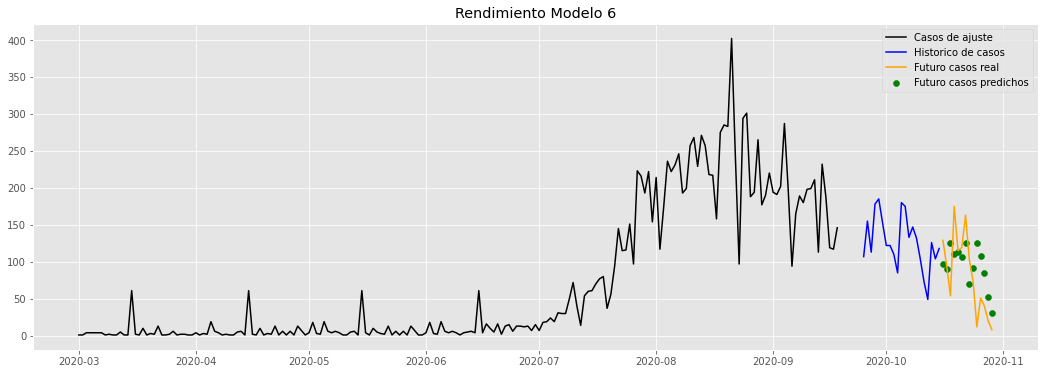

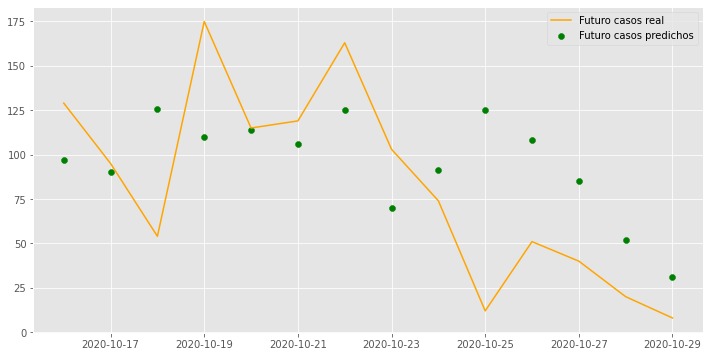

In [68]:
fig = plt.figure(figsize=(18,6))
plt.title('Rendimiento Modelo 6')
# plotear los valores de entrenamiento
plt.plot(final_data_train.index, scaler.inverse_transform(final_data_train.values)[:,col_to_predict], c='black', label='Casos de ajuste');
# plotear la última ventana
plt.plot(last_future_values_x.index, scaler.inverse_transform(last_future_values_x.values)[:,col_to_predict], c='blue', label='Historico de casos');
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, predicted_y_values_inverse, c='green', label='Futuro casos predichos');
plt.legend()
plt.show();
fig = plt.figure(figsize=(12,6))
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, predicted_y_values_inverse, c='green', label='Futuro casos predichos');
plt.legend()
plt.show()

In [65]:
# Guardar el mejor modelo y scaler
best_model_6.save('model_6/best_model_6.h5')
# save the scaler
pkl.dump(scaler, open('model_6/scaler_model_6.pkl', 'wb'))
# Guardar un archivo con el orden de los países
np.savetxt(fname='model_6/order_keys_list.txt',X=final_data_test.keys(),fmt='%s')

In [66]:
!zip -r model_6.zip model_6/*

  adding: model_6/best_model_6.h5 (deflated 14%)
  adding: model_6/oracle.json (deflated 55%)
  adding: model_6/order_keys_list.txt (deflated 30%)
  adding: model_6/scaler_model_6.pkl (deflated 8%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/ (stored 0%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/checkpoints/ (stored 0%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/checkpoints/epoch_0/ (stored 0%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/checkpoints/epoch_0/checkpoint.index (deflated 58%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: model_6/trial_04a2872c39c27675253d5185ec37bac7/trial.json (deflated 72%)
  adding: model_6/trial_0990028b1b444cda42ca10341fd97c37/ (stored 0%)
  adding: model_6/trial_0990028b1b444cda42ca10341fd97c37/checkpoints/ (st

## Modelo 7 RNN autoregresivo sobre BUCARAMANGA

In [45]:
# crear los datasets para entrenamiento y test según las fechas
final_data = df_join.loc[(df_join.index>=initial_date)&(df_join.index<=final_date)]
final_data_train = final_data.loc[final_data.index<=train_final_date]
final_data_test =  final_data.loc[final_data.index>train_final_date]

In [46]:
# número de series a usar
feature_dim = 1
# indice de la columna a predecir
col_to_predict = 0 # Columna casos nuevos

In [47]:
# Crear el dataset de entrenamiento
final_data_train, scaler  = series_transformer(final_data_train['BUCARAMANGA'].to_frame(), standarization=True, scaler=None)
dataset_train = windowed_dataset(final_data_train['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [48]:
# crear el dataset de test
# transformar la de test 
final_data_test, scaler = series_transformer(final_data_test['BUCARAMANGA'].to_frame(), standarization=True, scaler=scaler)
dataset_test = windowed_dataset(final_data_test['BUCARAMANGA'].values.reshape(-1,1).astype(np.float32), 
                                 past_window=window_size,
                                 batch_size=batch_size, 
                                 future_window = future_steps,
                                 col_test_series=col_to_predict)

In [100]:
# modelo autoregresivo
class autoregressive_model(tf.keras.Model):
  def __init__(self, units, layers,out_steps, num_features):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    # Empaquetar la celdas apiladas LSTM en una red RNN y retornar el estado
    self.rnn_cells = [tf.keras.layers.LSTMCell(units) for _ in range(layers)]
    self.lstm_cell = tf.keras.layers.StackedRNNCells(self.rnn_cells)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    # la densa predice el numero de dimensiones de salida para cada predicción
    # en este caso siempre es 1 porque solo se quiere predecir la serie de Bga
    self.dense1 = tf.keras.layers.Dense(units*2)
    self.dense2 = tf.keras.layers.Dense(num_features)
  
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    x = self.dense1(x) 
    prediction = self.dense2(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Para capturar todas las predicciones a realizar
    predictions = []
    # Iniciar la lstm
    prediction, state = self.warmup(inputs)

    # Insertar la primera predicción 
    predictions.append(prediction)

    # Obtener todas las demás prediccioens
    for n in range(1, self.out_steps):
        # Usando la última predicción como entrada 
        x = prediction
        # Ejecutar cada paso LSTM
        x, state = self.lstm_cell(x, states=state,
                                training=training)
        # Convertir la salida de la LSTM a una predicción
        x = self.dense1(x)
        prediction = self.dense2(x)
        # Almacenar la predicción
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    return predictions   

In [101]:
def build_autoregressiv_model(hp):
    # contruir el modelo
    tf.keras.backend.clear_session()
    gc.collect()
    model = autoregressive_model(units=64, layers=3, out_steps=future_steps, num_features=feature_dim)
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

In [103]:
# crear el objeto que va a ejecutar la optmización del modelo
tuner = kt.Hyperband(
    build_autoregressiv_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    project_name='model_7'
)

In [104]:
# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dataset_train,
             validation_data=dataset_test,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])

Epoch 1/2
168/168 [==============================] - 19s 113ms/step - loss: 0.4442 - mean_absolute_error: 0.4799 - val_loss: 0.9726 - val_mean_absolute_error: 0.8556
Epoch 2/2
168/168 [==============================] - 19s 111ms/step - loss: 0.2147 - mean_absolute_error: 0.3085 - val_loss: 1.6272 - val_mean_absolute_error: 1.1729


Epoch 1/2
168/168 [==============================] - 20s 118ms/step - loss: 0.9720 - mean_absolute_error: 0.8137 - val_loss: 0.2679 - val_mean_absolute_error: 0.4396
Epoch 2/2
168/168 [==============================] - 18s 107ms/step - loss: 0.7762 - mean_absolute_error: 0.7074 - val_loss: 0.2116 - val_mean_absolute_error: 0.3768


Epoch 1/2
168/168 [==============================] - 19s 111ms/step - loss: 0.9951 - mean_absolute_error: 0.8270 - val_loss: 0.2703 - val_mean_absolute_error: 0.4423
Epoch 2/2
168/168 [==============================] - 18s 106ms/step - loss: 0.7739 - mean_absolute_error: 0.7096 - val_loss: 0.2111 - val_mean_absolute_error: 0.3742


Epoch 1/2
168/168 [==============================] - 19s 114ms/step - loss: 0.4992 - mean_absolute_error: 0.5066 - val_loss: 0.9724 - val_mean_absolute_error: 0.8547
Epoch 2/2
168/168 [==============================] - 17s 104ms/step - loss: 0.2271 - mean_absolute_error: 0.3188 - val_loss: 1.5748 - val_mean_absolute_error: 1.1450


Epoch 1/2
168/168 [==============================] - 18s 109ms/step - loss: 0.2170 - mean_absolute_error: 0.3083 - val_loss: 2.4507 - val_mean_absolute_error: 1.4901
Epoch 2/2
168/168 [==============================] - 17s 103ms/step - loss: 0.1479 - mean_absolute_error: 0.2556 - val_loss: 1.4111 - val_mean_absolute_error: 1.0889


Epoch 1/2
168/168 [==============================] - 19s 114ms/step - loss: 1.0966 - mean_absolute_error: 0.8751 - val_loss: 0.3298 - val_mean_absolute_error: 0.4908
Epoch 2/2
168/168 [==============================] - 19s 115ms/step - loss: 1.0838 - mean_absolute_error: 0.8691 - val_loss: 0.3255 - val_mean_absolute_error: 0.4874


Epoch 1/2
168/168 [==============================] - 19s 111ms/step - loss: 0.5107 - mean_absolute_error: 0.5052 - val_loss: 1.7711 - val_mean_absolute_error: 1.2451
Epoch 2/2
168/168 [==============================] - 18s 105ms/step - loss: 0.3878 - mean_absolute_error: 0.4375 - val_loss: 0.9697 - val_mean_absolute_error: 0.8652


Epoch 1/2
168/168 [==============================] - 19s 113ms/step - loss: 0.2844 - mean_absolute_error: 0.3774 - val_loss: 1.4830 - val_mean_absolute_error: 1.1179
Epoch 2/2
168/168 [==============================] - 18s 109ms/step - loss: 0.1370 - mean_absolute_error: 0.2403 - val_loss: 2.0345 - val_mean_absolute_error: 1.3438


Epoch 1/2
168/168 [==============================] - 19s 111ms/step - loss: 0.4548 - mean_absolute_error: 0.4684 - val_loss: 1.1013 - val_mean_absolute_error: 0.9216
Epoch 2/2
168/168 [==============================] - 17s 101ms/step - loss: 0.2046 - mean_absolute_error: 0.2998 - val_loss: 1.4136 - val_mean_absolute_error: 1.0791


Epoch 1/2
168/168 [==============================] - 20s 120ms/step - loss: 0.9646 - mean_absolute_error: 0.8120 - val_loss: 0.2620 - val_mean_absolute_error: 0.4349
Epoch 2/2
168/168 [==============================] - 17s 102ms/step - loss: 0.7489 - mean_absolute_error: 0.7009 - val_loss: 0.2079 - val_mean_absolute_error: 0.3702


Epoch 1/2
168/168 [==============================] - 19s 111ms/step - loss: 1.0923 - mean_absolute_error: 0.8725 - val_loss: 0.3271 - val_mean_absolute_error: 0.4888
Epoch 2/2
168/168 [==============================] - 18s 110ms/step - loss: 1.0739 - mean_absolute_error: 0.8639 - val_loss: 0.3208 - val_mean_absolute_error: 0.4840


Epoch 1/2
168/168 [==============================] - 18s 109ms/step - loss: 0.6393 - mean_absolute_error: 0.5100 - val_loss: 1.6296 - val_mean_absolute_error: 1.1861
Epoch 2/2
168/168 [==============================] - 18s 107ms/step - loss: 0.2234 - mean_absolute_error: 0.3047 - val_loss: 1.8303 - val_mean_absolute_error: 1.2574


Epoch 1/2
168/168 [==============================] - 19s 113ms/step - loss: 1.0981 - mean_absolute_error: 0.8757 - val_loss: 0.3312 - val_mean_absolute_error: 0.4915
Epoch 2/2
168/168 [==============================] - 19s 111ms/step - loss: 1.0820 - mean_absolute_error: 0.8685 - val_loss: 0.3256 - val_mean_absolute_error: 0.4871


Epoch 1/2
168/168 [==============================] - 19s 116ms/step - loss: 0.2257 - mean_absolute_error: 0.3305 - val_loss: 1.8425 - val_mean_absolute_error: 1.2699
Epoch 2/2
168/168 [==============================] - 18s 106ms/step - loss: 0.1422 - mean_absolute_error: 0.2459 - val_loss: 1.6966 - val_mean_absolute_error: 1.2128


Epoch 1/2
168/168 [==============================] - 17s 103ms/step - loss: 0.6305 - mean_absolute_error: 0.5398 - val_loss: 1.3207 - val_mean_absolute_error: 1.0478
Epoch 2/2
168/168 [==============================] - 17s 103ms/step - loss: 0.1866 - mean_absolute_error: 0.2958 - val_loss: 1.5963 - val_mean_absolute_error: 1.1727


Epoch 1/2
168/168 [==============================] - 19s 112ms/step - loss: 0.3974 - mean_absolute_error: 0.4447 - val_loss: 1.0658 - val_mean_absolute_error: 0.9021
Epoch 2/2
168/168 [==============================] - 18s 105ms/step - loss: 0.2168 - mean_absolute_error: 0.3089 - val_loss: 1.3203 - val_mean_absolute_error: 1.0348


Epoch 1/2
168/168 [==============================] - 20s 118ms/step - loss: 0.9890 - mean_absolute_error: 0.8226 - val_loss: 0.2646 - val_mean_absolute_error: 0.4376
Epoch 2/2
168/168 [==============================] - 19s 113ms/step - loss: 0.7363 - mean_absolute_error: 0.6879 - val_loss: 0.2088 - val_mean_absolute_error: 0.3657


Epoch 1/2
168/168 [==============================] - 18s 109ms/step - loss: 0.2510 - mean_absolute_error: 0.3483 - val_loss: 1.6197 - val_mean_absolute_error: 1.1796
Epoch 2/2
168/168 [==============================] - 17s 101ms/step - loss: 0.1347 - mean_absolute_error: 0.2339 - val_loss: 1.8479 - val_mean_absolute_error: 1.2732


Epoch 1/2
168/168 [==============================] - 18s 107ms/step - loss: 0.6707 - mean_absolute_error: 0.5676 - val_loss: 3.2740 - val_mean_absolute_error: 1.7470
Epoch 2/2
168/168 [==============================] - 17s 99ms/step - loss: 0.2589 - mean_absolute_error: 0.3376 - val_loss: 2.5184 - val_mean_absolute_error: 1.5158


Epoch 1/2
168/168 [==============================] - 18s 108ms/step - loss: 1.0817 - mean_absolute_error: 0.8683 - val_loss: 0.3272 - val_mean_absolute_error: 0.4884
Epoch 2/2
168/168 [==============================] - 17s 102ms/step - loss: 1.0680 - mean_absolute_error: 0.8620 - val_loss: 0.3225 - val_mean_absolute_error: 0.4847


INFO:tensorflow:Oracle triggered exit


In [105]:
best_model_7 = tuner.get_best_models(1)[0]

In [106]:
best_hyperparameters_7 = tuner.get_best_hyperparameters(1)[0]

In [107]:
vars(best_hyperparameters_7)

{'_scopes': [],
 '_space': {'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01)},
 'values': {'clipvalue': 5.0,
  'learning_rate': 1e-05,
  'tuner/bracket': 3,
  'tuner/epochs': 2,
  'tuner/initial_epoch': 0,
  'tuner/round': 0}}

In [108]:
best_model_7.evaluate(dataset_test)

7/7 [==============================] - 0s 12ms/step - loss: 0.2088 - mean_absolute_error: 0.3657


[0.2087867259979248, 0.3656659722328186]

In [109]:
# predecir la última ventana de tiempo
last_future_values_x = final_data_test['BUCARAMANGA'].to_frame().iloc[-(window_size+future_steps):-future_steps,col_to_predict]
last_future_values_y = final_data_test['BUCARAMANGA'].to_frame().iloc[-future_steps:,col_to_predict]

In [110]:
last_future_values_y_preds = best_model_7.predict(np.expand_dims(last_future_values_x.values.reshape(-1,1), axis=0))

In [111]:
# invertir los valores reales
real_y_values_inverse = scaler.inverse_transform(last_future_values_y.values)

In [112]:
real_y_pred_values_inverse = scaler.inverse_transform(last_future_values_y_preds.ravel())

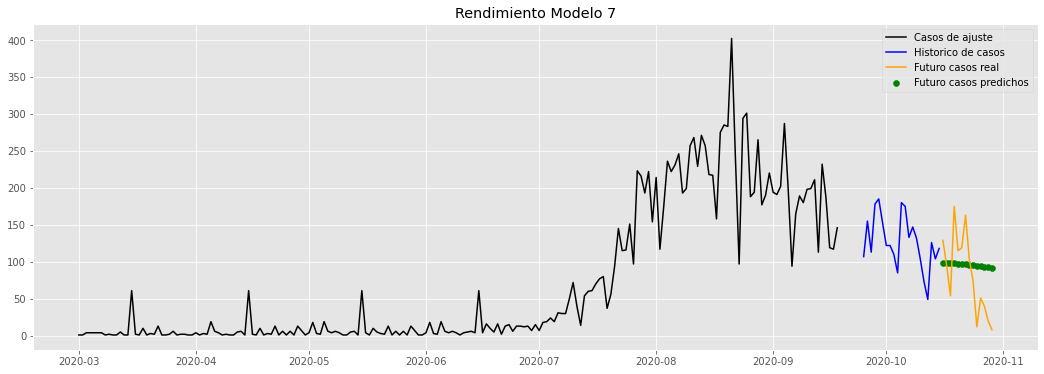

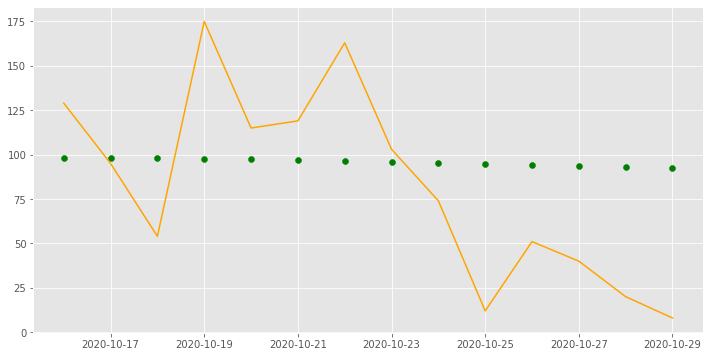

In [114]:
fig = plt.figure(figsize=(18,6))
plt.title('Rendimiento Modelo 7')
# plotear los valores de entrenamiento
plt.plot(final_data_train.index, scaler.inverse_transform(final_data_train.values.ravel()), c='black', label='Casos de ajuste');
# plotear la última ventana
plt.plot(last_future_values_x.index, scaler.inverse_transform(last_future_values_x.values), c='blue', label='Historico de casos');
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, real_y_pred_values_inverse, c='green', label='Futuro casos predichos');
plt.legend()
plt.show();
fig = plt.figure(figsize=(12,6))
plt.plot(last_future_values_y.index, real_y_values_inverse, c='orange', label='Futuro casos real');
plt.scatter(last_future_values_y.index, real_y_pred_values_inverse, c='green', label='Futuro casos predichos');
plt.show();

In [116]:
# Guardar el mejor modelo y scaler
best_model_7.save('model_7/best_model_7.tf', save_format="tf")
# save the scaler
pkl.dump(scaler, open('model_7/scaler_model_7.pkl', 'wb'))
# guardar los pesos
best_model_7.save_weights(filepath='model_7/best_weights_7.h5', save_format='h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_7/best_model_7.tf/assets


In [120]:
!zip -r model_7.zip model_7/*

  adding: model_7/best_model_7.tf/ (stored 0%)
  adding: model_7/best_model_7.tf/assets/ (stored 0%)
  adding: model_7/best_model_7.tf/variables/ (stored 0%)
  adding: model_7/best_model_7.tf/variables/variables.index (deflated 59%)
  adding: model_7/best_model_7.tf/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: model_7/best_model_7.tf/saved_model.pb (deflated 92%)
  adding: model_7/best_weights_7.h5 (deflated 12%)
  adding: model_7/oracle.json (deflated 55%)
  adding: model_7/scaler_model_7.pkl (deflated 25%)
  adding: model_7/trial_0fe2b46f76984924e0bed9f3e7b3df1e/ (stored 0%)
  adding: model_7/trial_0fe2b46f76984924e0bed9f3e7b3df1e/checkpoints/ (stored 0%)
  adding: model_7/trial_0fe2b46f76984924e0bed9f3e7b3df1e/checkpoints/epoch_0/ (stored 0%)
  adding: model_7/trial_0fe2b46f76984924e0bed9f3e7b3df1e/checkpoints/epoch_0/checkpoint.index (deflated 70%)
  adding: model_7/trial_0fe2b46f76984924e0bed9f3e7b3df1e/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: mod